In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
#%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

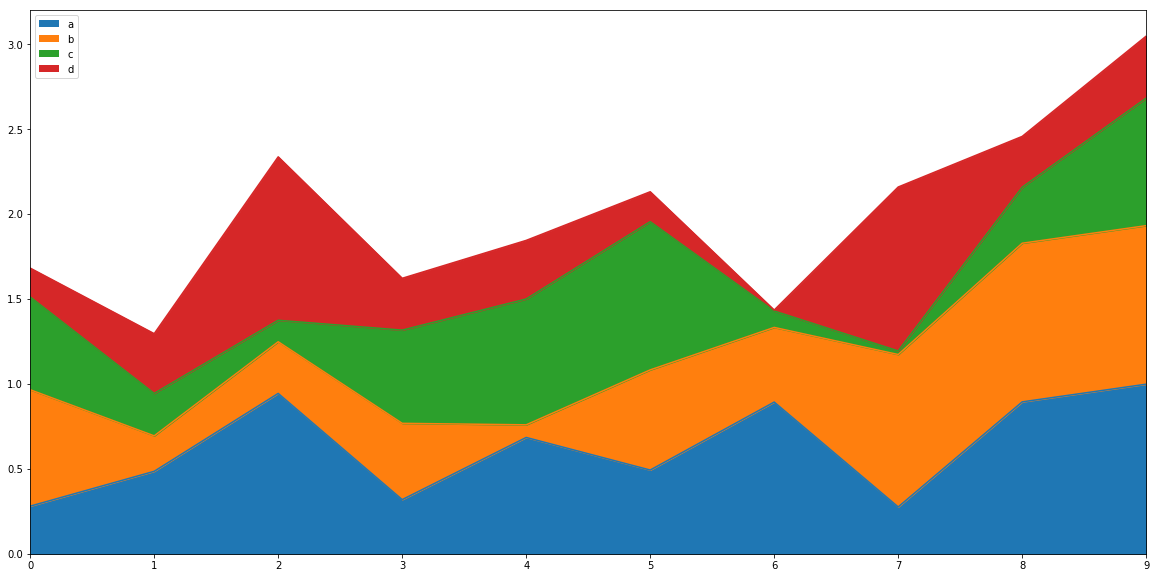

In [13]:
x = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])
x.plot.area()
#np.random.rand(3,2)

In [4]:
db_connection =  mysql.connector.connect(
        user= "local",
        password= "local",
        database= "trajectories"
    );
def qry(sql):
    #print sql;
    return pd.read_sql(sql, con=db_connection)

In [5]:
ecos = qry('select ecosystem, count(distinct(author)) from traj where year=2013 group by ecosystem;')

In [6]:
ecos


ecosystem  count(distinct(author))
0        Atom                      271
1       Cargo                      591
2   CocoaPods                     9048
3        CPAN                     1619
4        CRAN                      834
5          Go                    17697
6     Hackage                     1865
7         Hex                      738
8         Lua                      316
9       Maven                    32265
10        NPM                    55439
11      NuGet                    16967
12  Packagist                    32992
13       Pypi                    28055
14   Rubygems                    36283
15   Stackage                      798

In [7]:
#qry('select ecosystem, count(distinct(author)) from traj where year=2013 and author in \
#(select distinct(author) from traj where year=2014 and ecosystem="CPAN") group by ecosystem')

# How many authors from this ecosystem contributed to each of the other ecosystems the previous year?  Counts might overlap.
def last_year_experience(eco, year):
    return qry('select ecosystem, count(distinct(author)) from traj where year=' + str(year-1) + ' and author in \
(select distinct(author) from traj where year=' + str(year) + ' and ecosystem="' + eco + '") group by ecosystem')

def previous_experience(eco, year):
    return qry('select ecosystem, count(distinct(author)) from traj where year<' + str(year) + ' and author in \
(select distinct(author) from traj where year=' + str(year) + ' and ecosystem="' + eco + '") group by ecosystem')

# Out of this year's contributors to E, how were their commits distributed across ecosystems last year?

# Of people who mostly contributed to E this year, what proportion of them primarily committed to some other ecosystem last year?
def last_year_primary(eco, year):
    return qry('select ecosystem, count(distinct(author)) from traj_top where year=' + str(year-1) 
              + ' and author in (select distinct(author) from traj where year=' + str(year) 
              + ' and ecosystem="' + eco + '") group by ecosystem')

# Of people who mostly contributed to E this year, what proportion of them primarily committed to some other ecosystem last year?
def this_year_primary(eco, year):
    return qry('select ecosystem, count(distinct(author)) from traj_top where year=' + str(year) 
              + ' and author in (select distinct(author) from traj where year=' + str(year) 
              + ' and ecosystem="' + eco + '") group by ecosystem')

# Generate a table of people's biggest contributed ecosystem for each year
#"SELECT t1.*
#FROM traj t1
#WHERE t1.commits = (
#  SELECT MAX(commits) FROM traj t2 where t2.year=t1.year and t1.author=t2.author
#) group by t1.author, t1.year"


#"select t1.* from traj t1 left join traj t2 on t1.author=t2.author and t1.year = t2.year and t1.count > t2.count where t2.count=null;"


In [17]:
def draw_ecosystem_influences(eco):
    mtd = 0

    for y in range(2000,2016):
        la = this_year_primary(eco, y)
        la = la.assign(fromyear = y)
        if not type(mtd) is pd.core.frame.DataFrame:
            mtd = la
        else:
            mtd = mtd.append(la)
    grid = pd.pivot_table(mtd,values="count(distinct(author))", index="fromyear", columns="ecosystem", fill_value=0)
    grid.plot.area(title=eco)
    grid = grid.divide(grid.sum(axis=1), axis=0)
    grid.plot.area(title=eco + " (proportional)")
    
def draw_ecosystem_influences_prior_year(eco):
    mtd = 0

    for y in range(2000,2016):
        la = last_year_primary(eco, y)
        la = la.assign(fromyear = y)
        if not type(mtd) is pd.core.frame.DataFrame:
            mtd = la
        else:
            mtd = mtd.append(la)
    grid = pd.pivot_table(mtd,values="count(distinct(author))", index="fromyear", columns="ecosystem", fill_value=0)
    grid.plot.area(title=eco)
    grid = grid.divide(grid.sum(axis=1), axis=0)
    grid.plot.area(title=eco + " (proportional)")

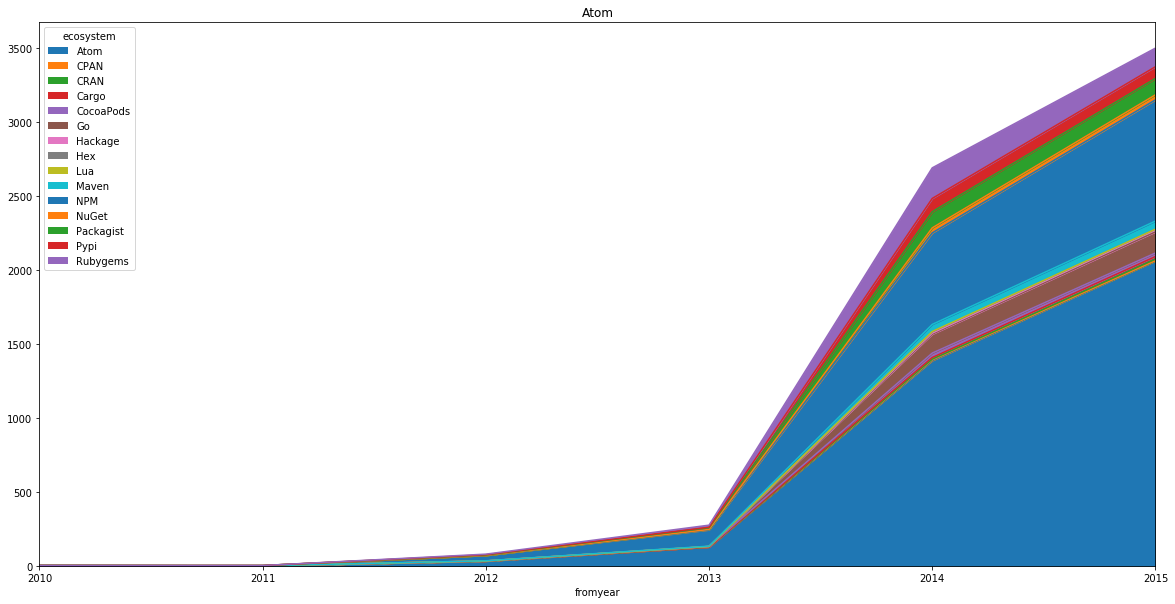

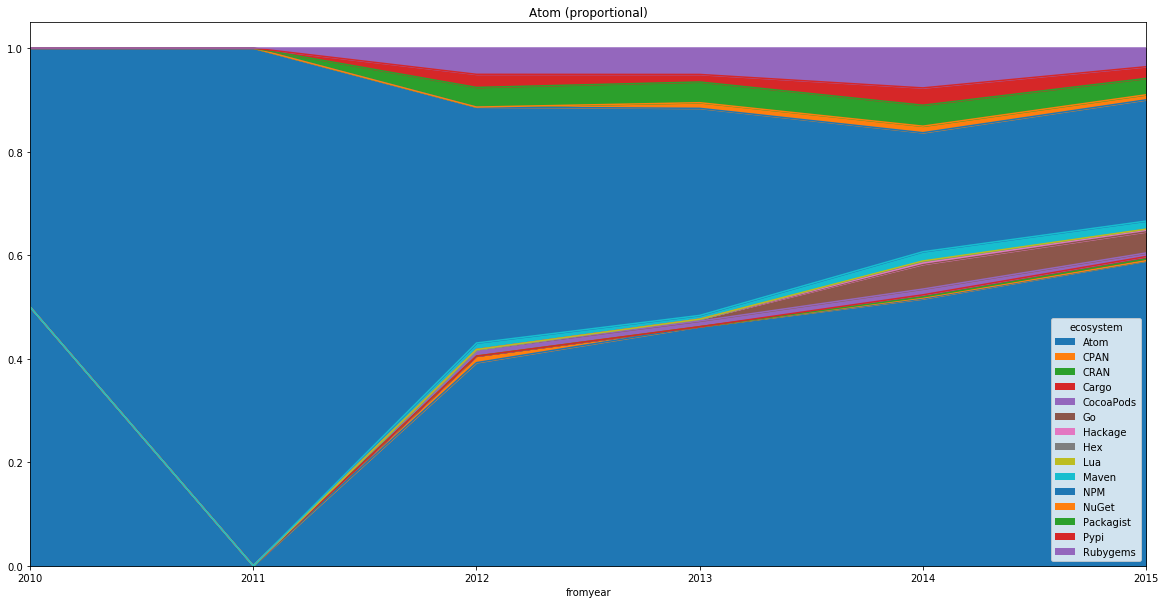

In [15]:
draw_ecosystem_influences("Atom")

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


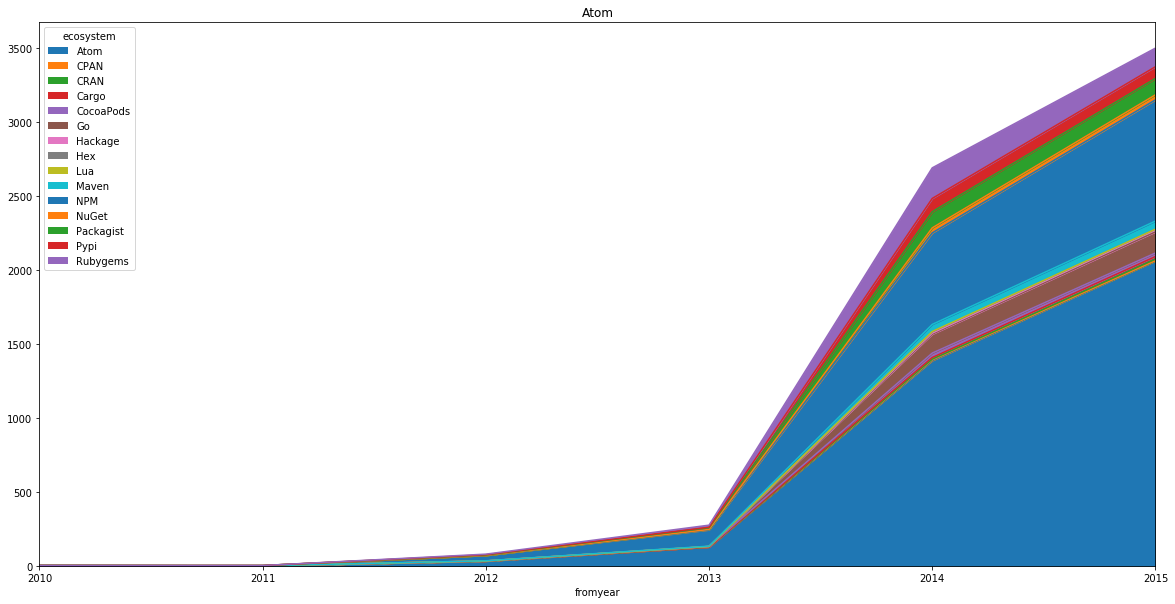

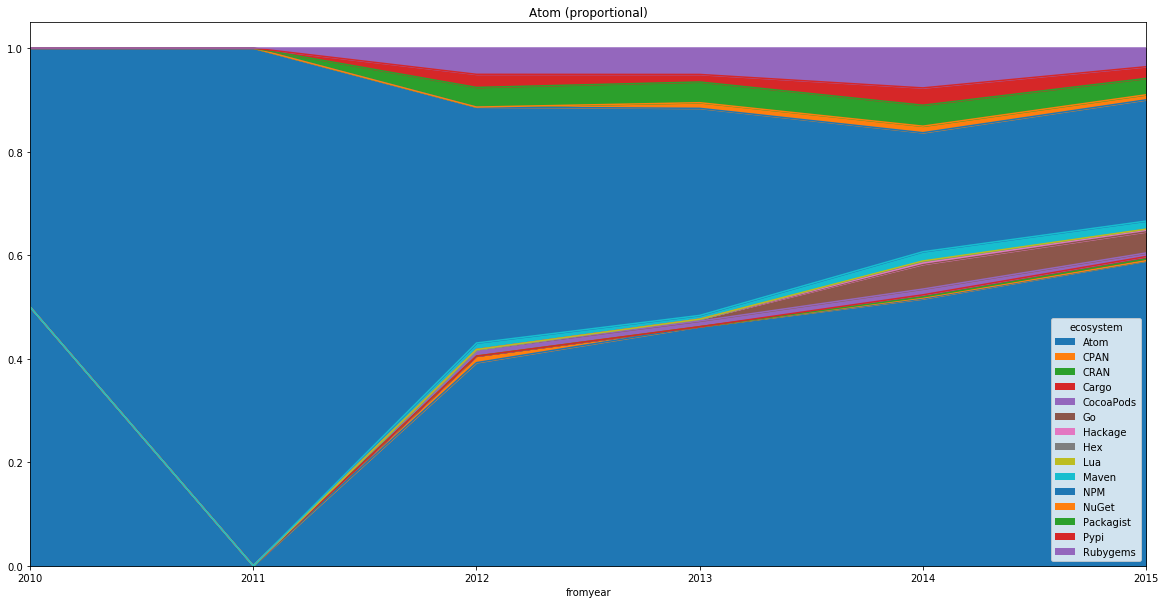

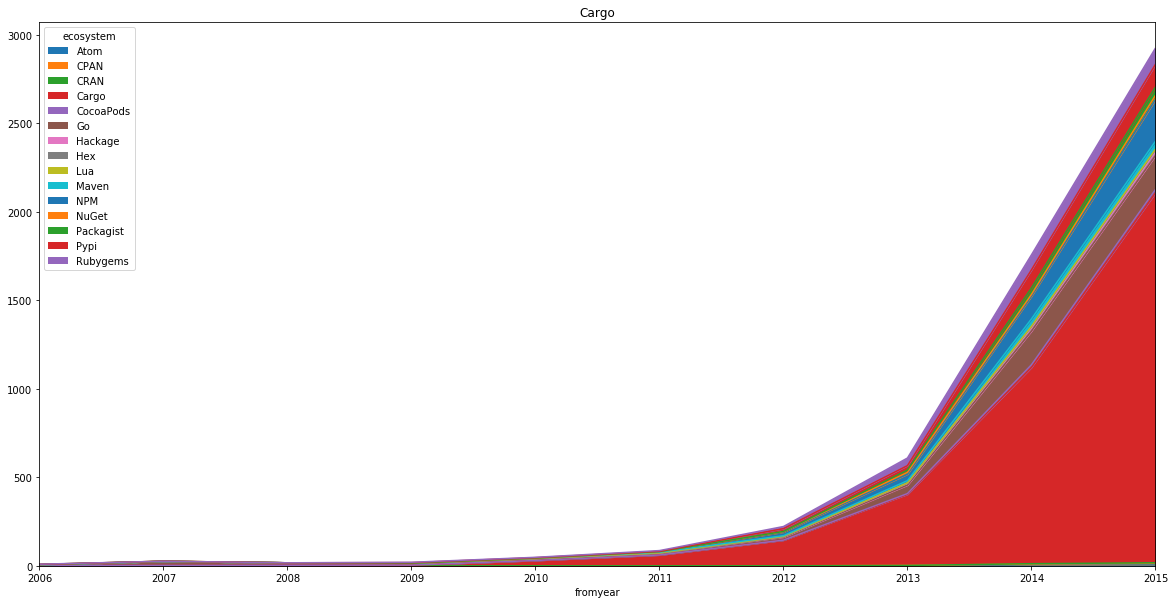

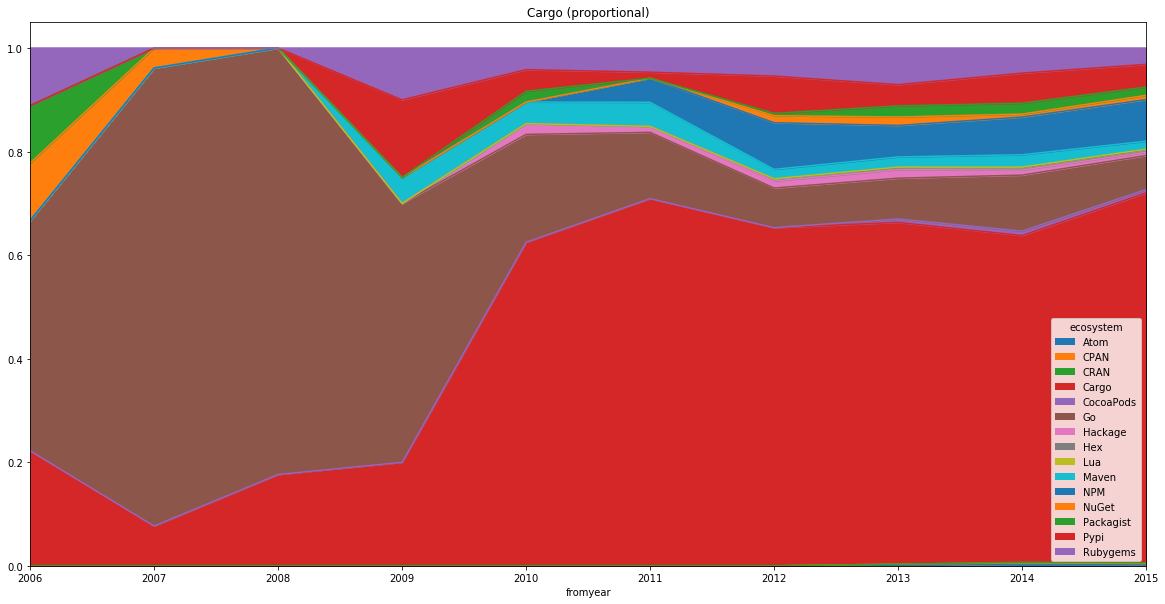

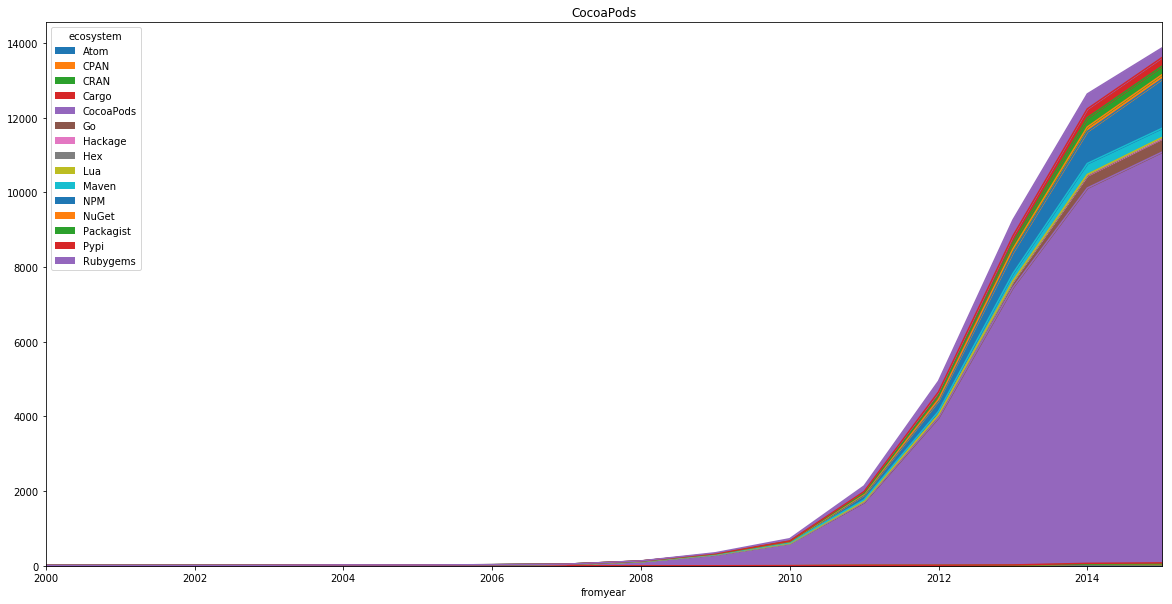

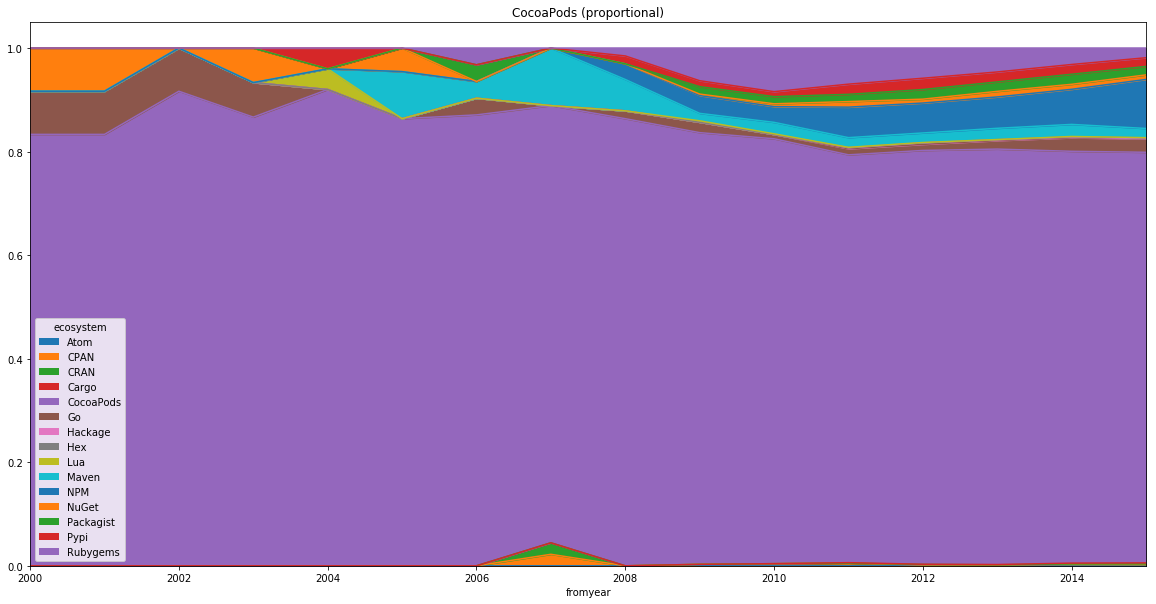

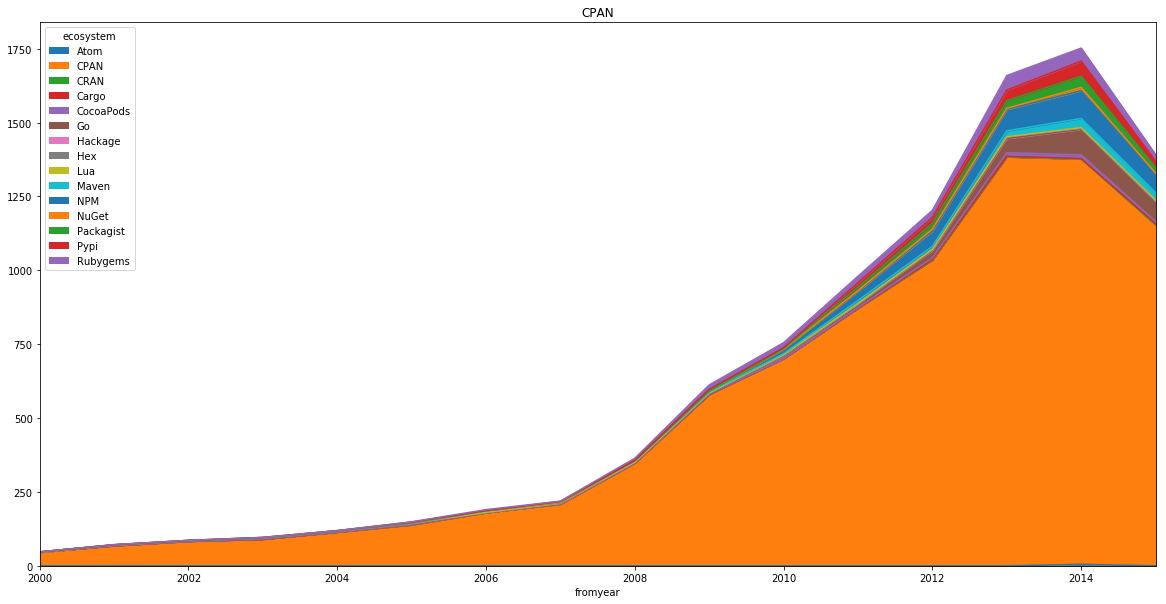

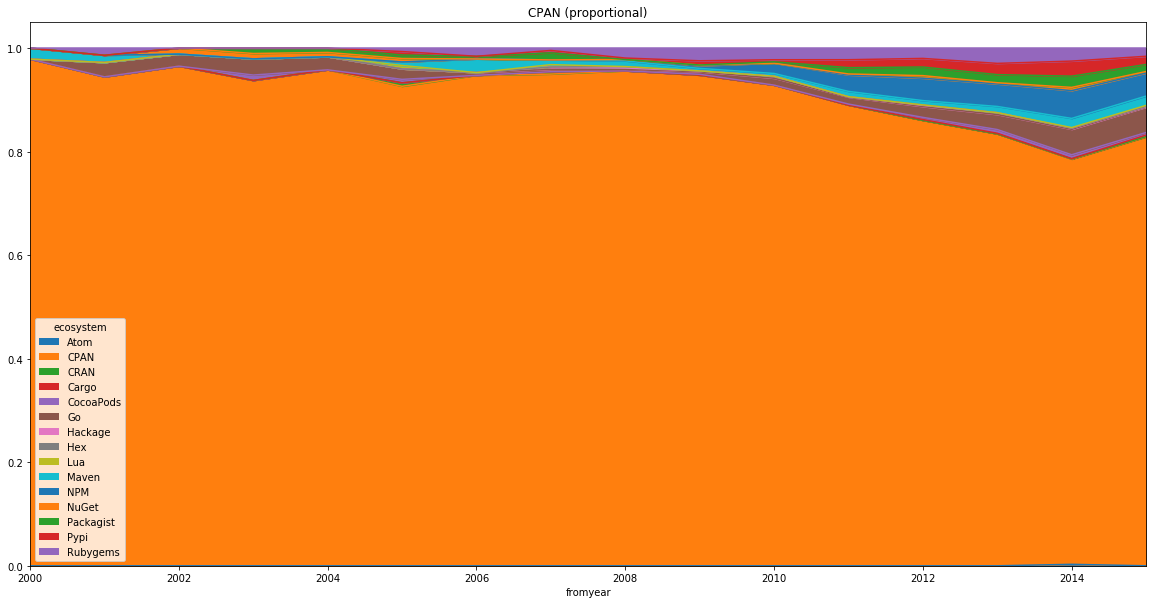

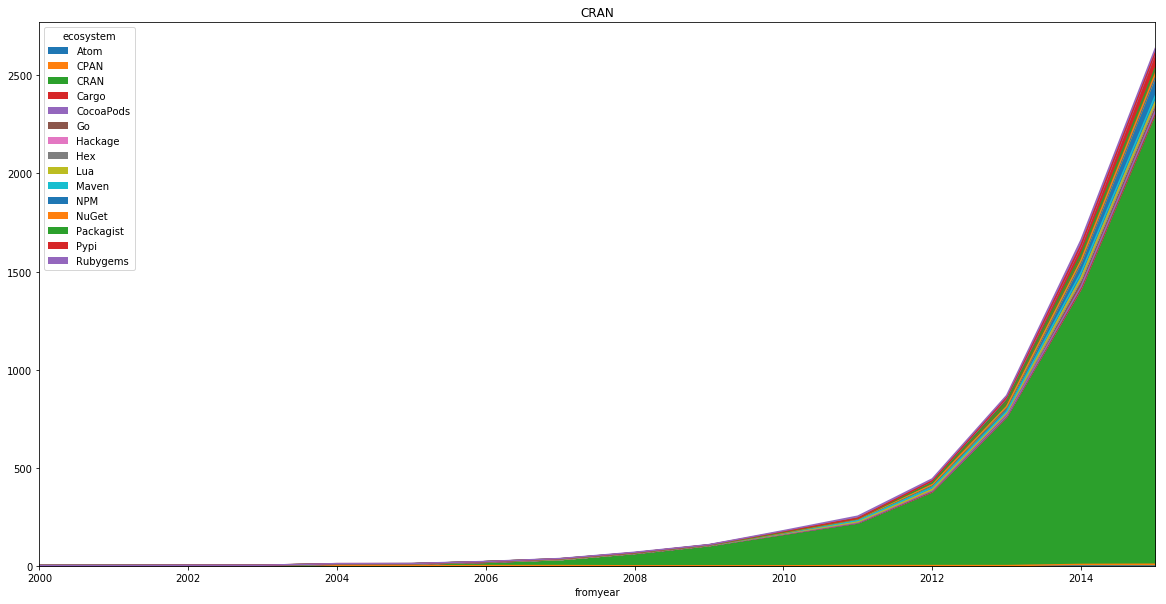

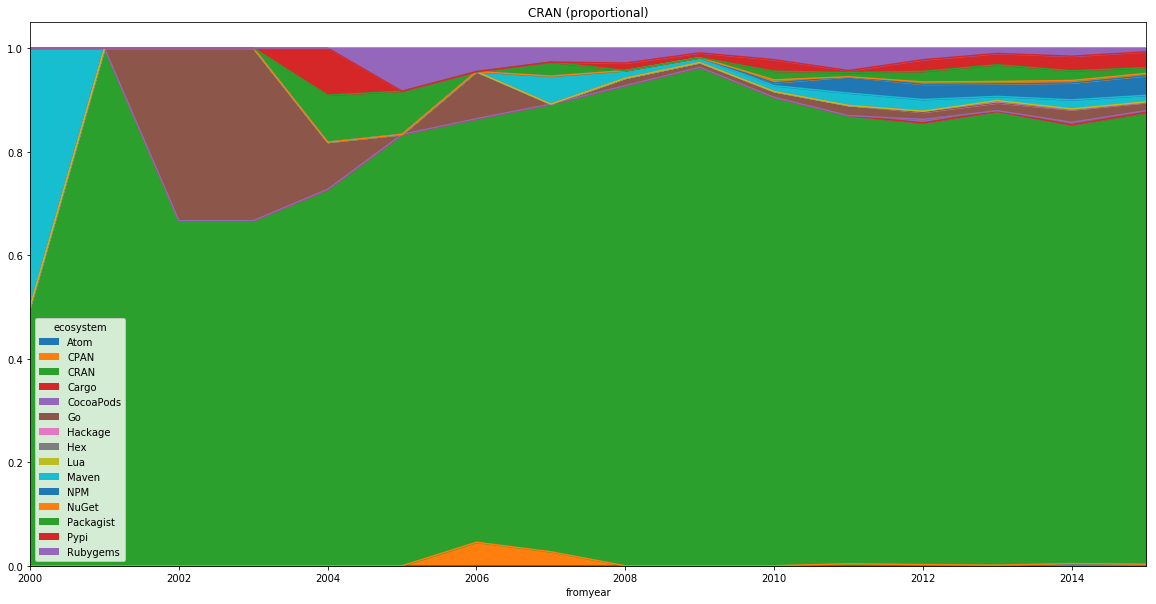

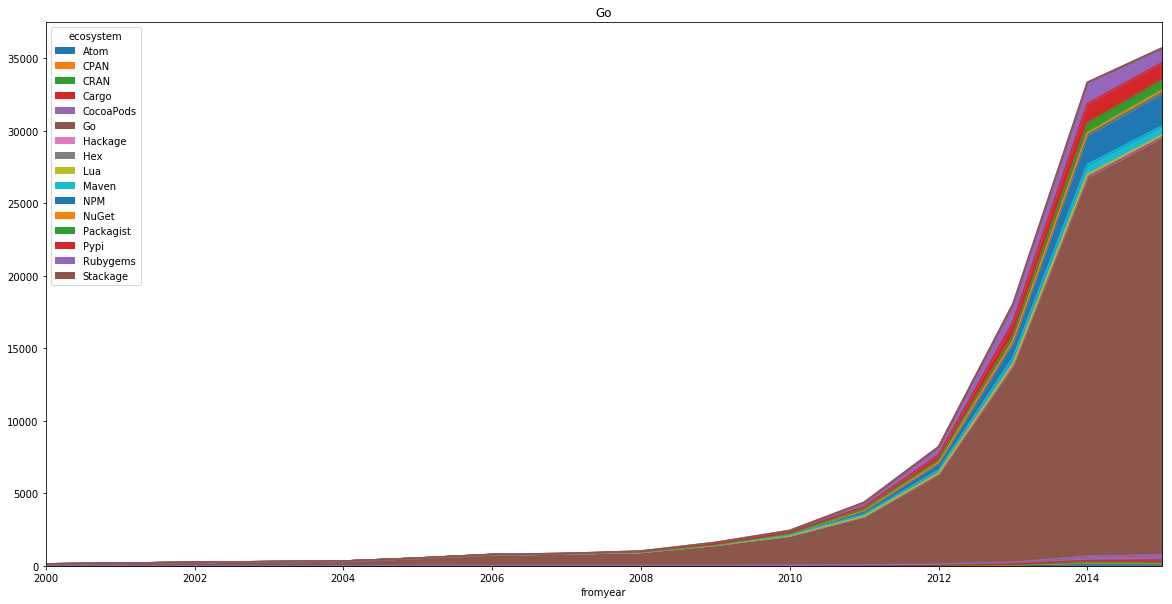

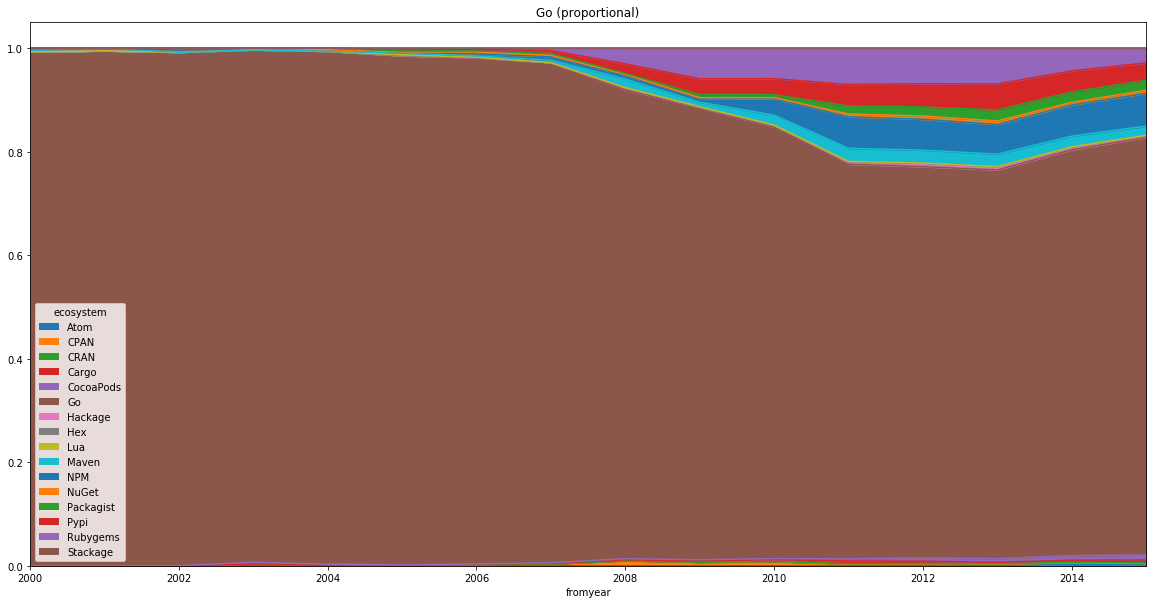

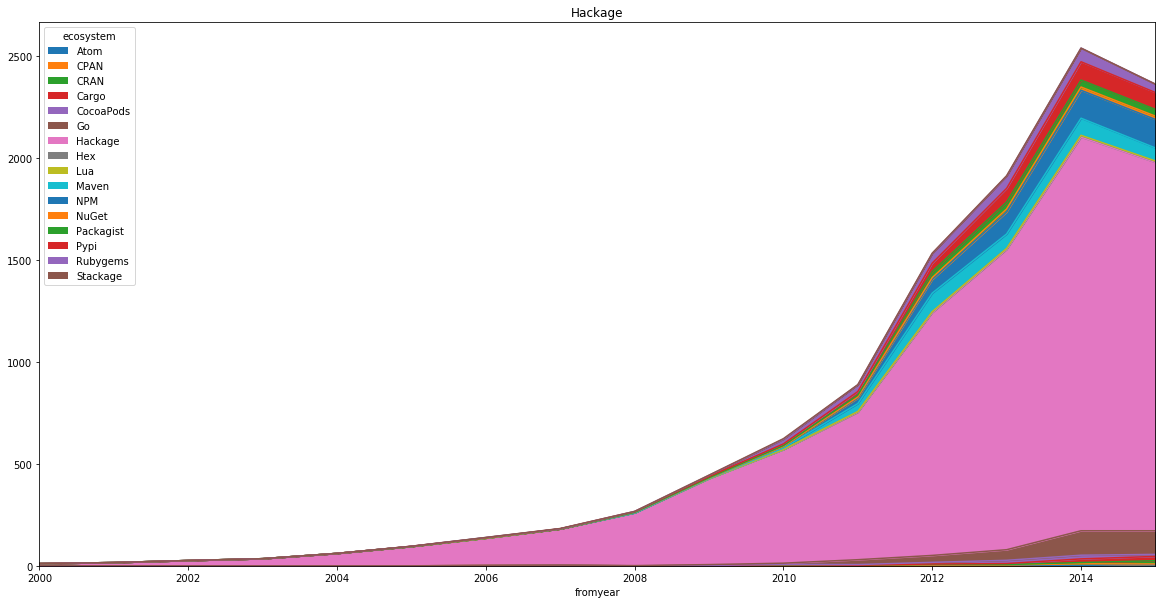

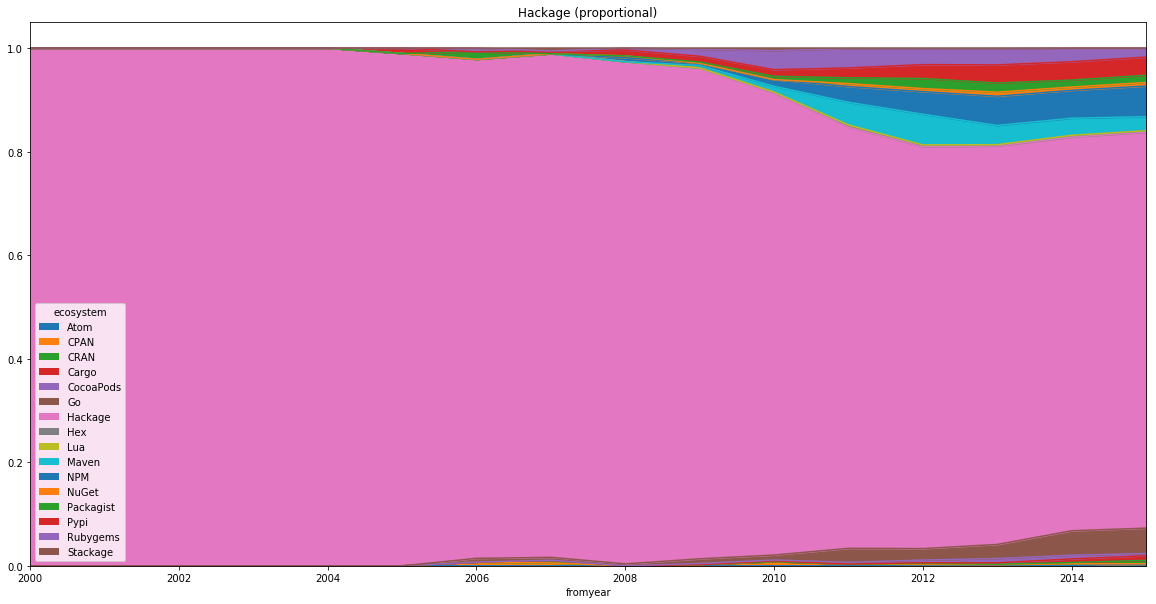

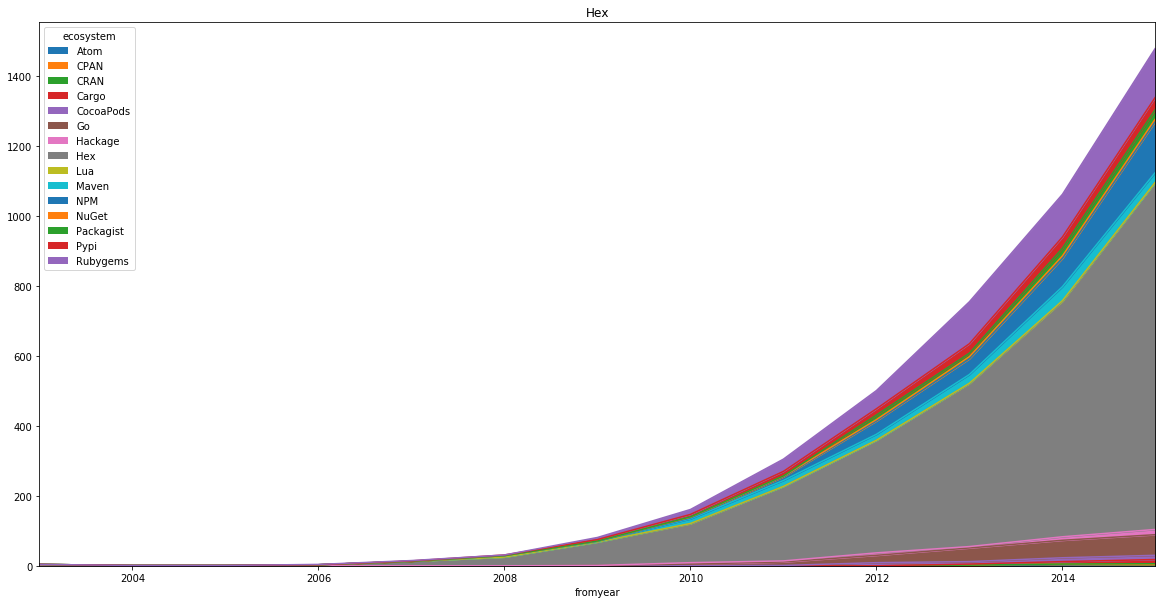

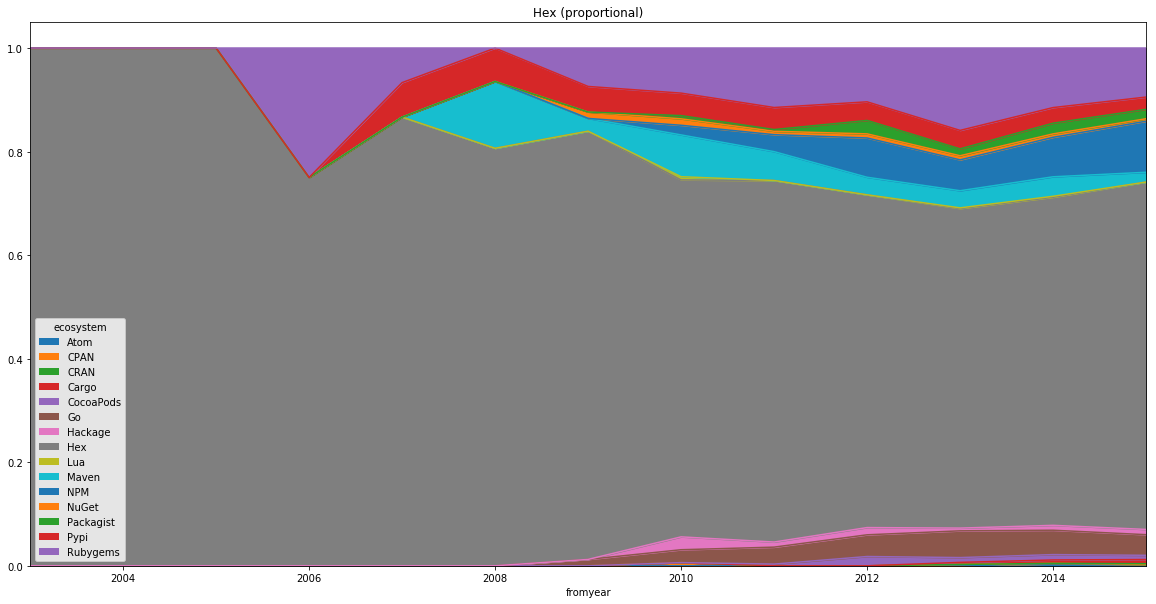

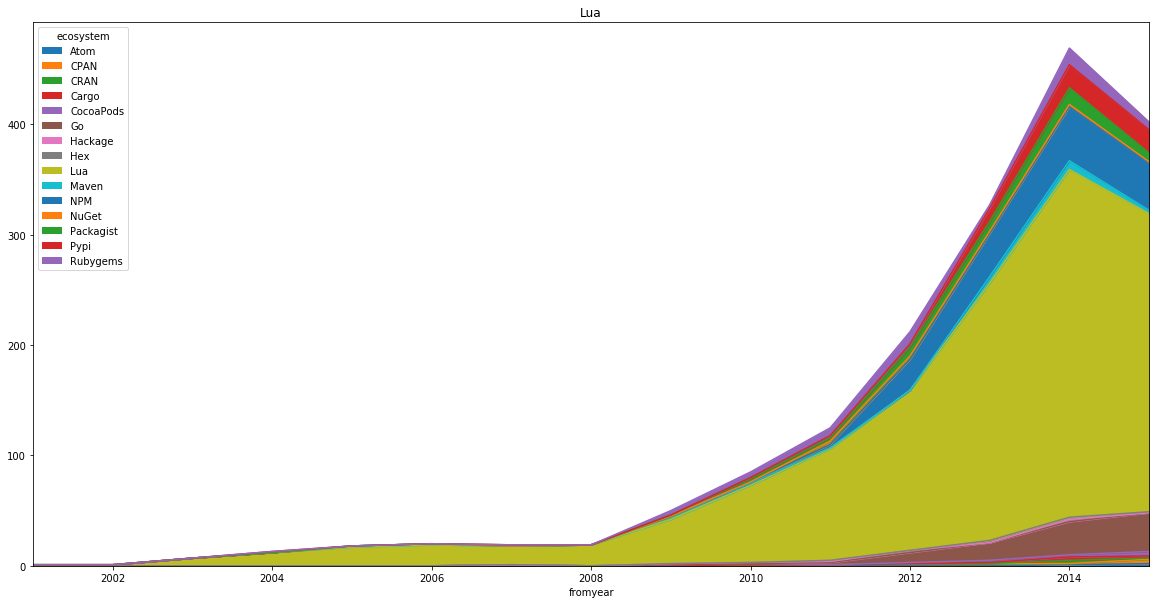

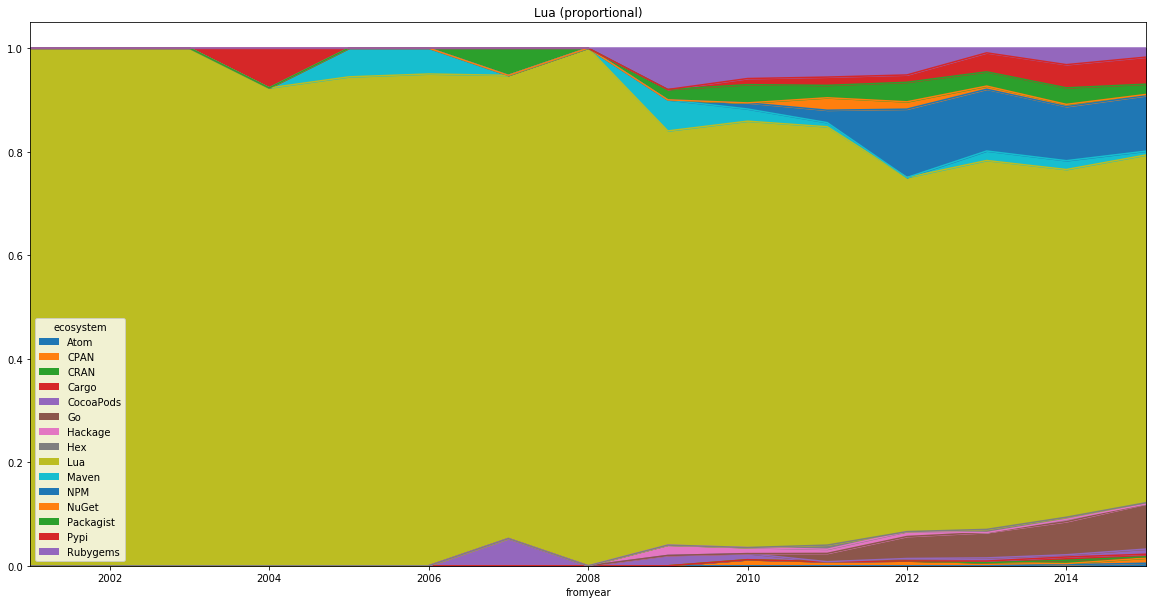

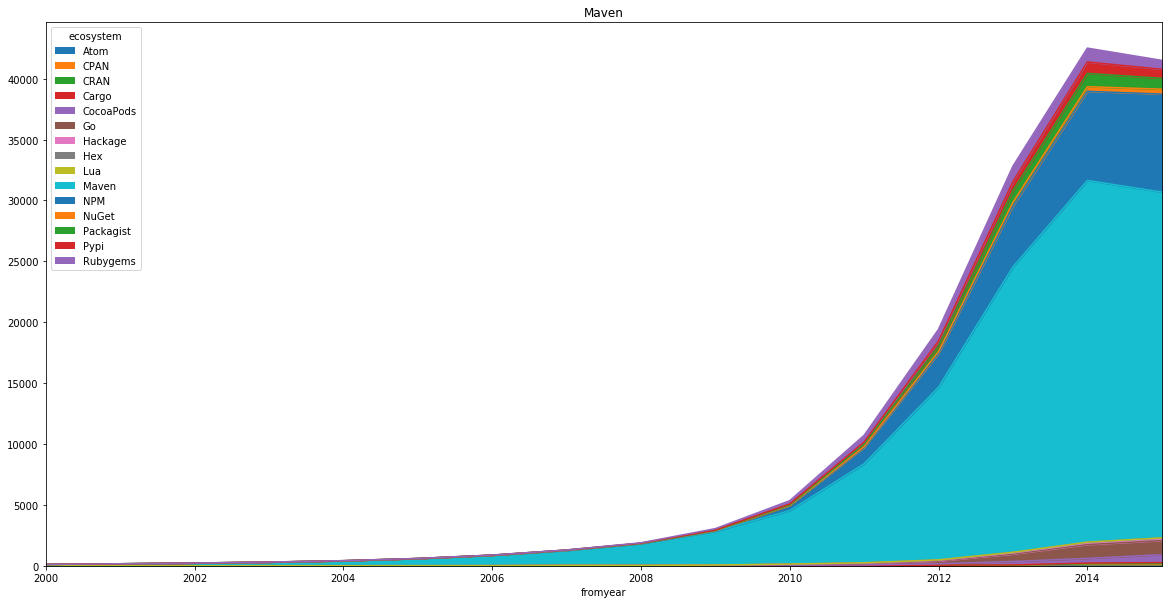

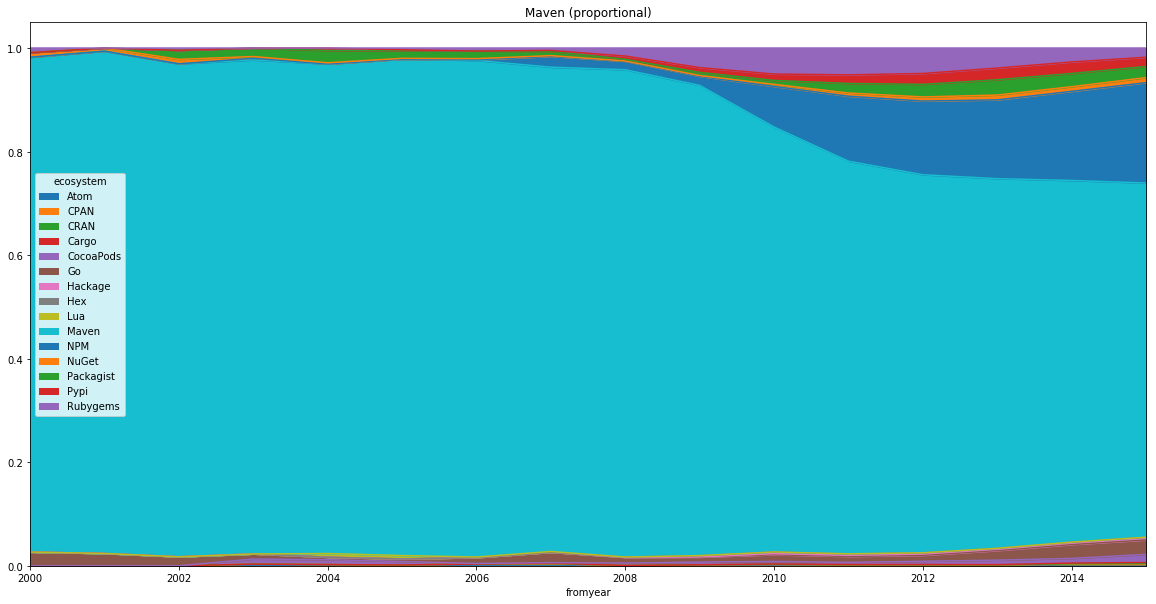

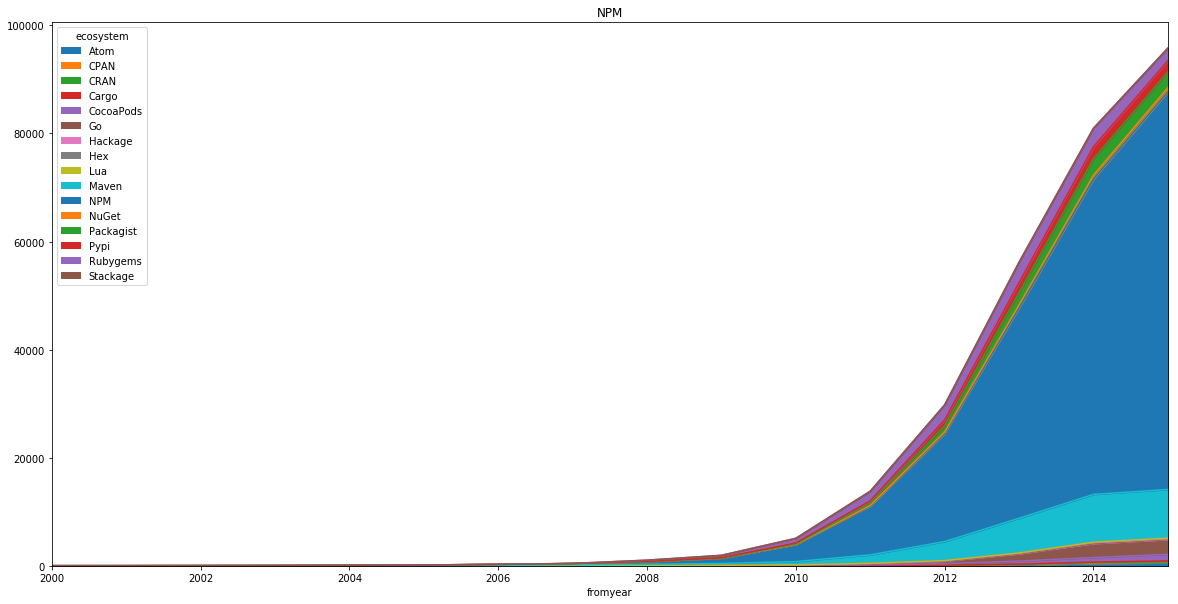

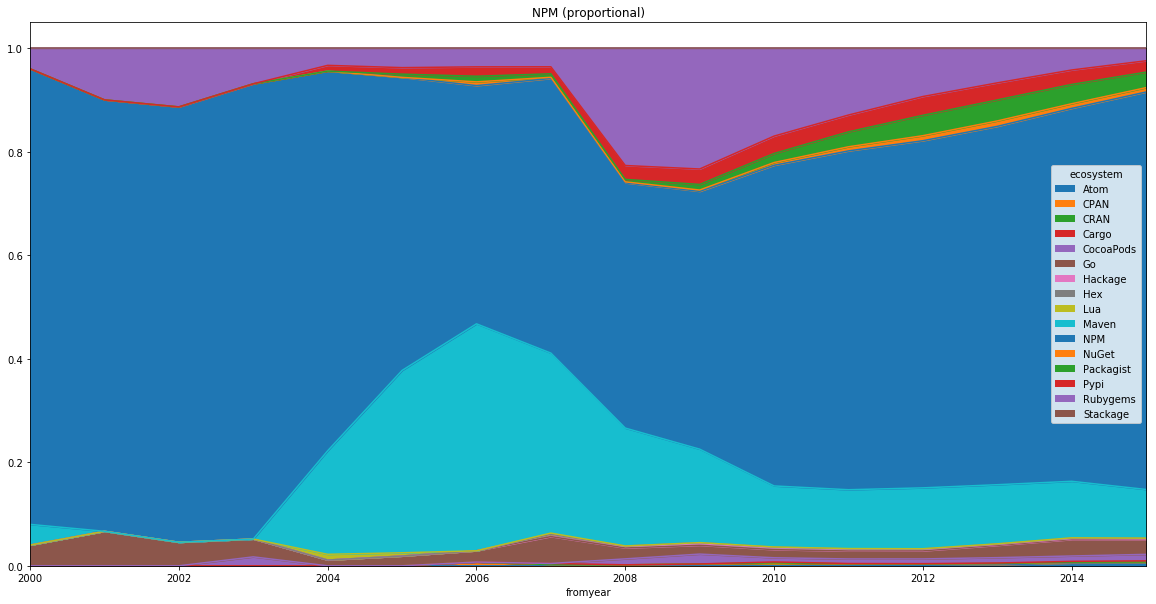

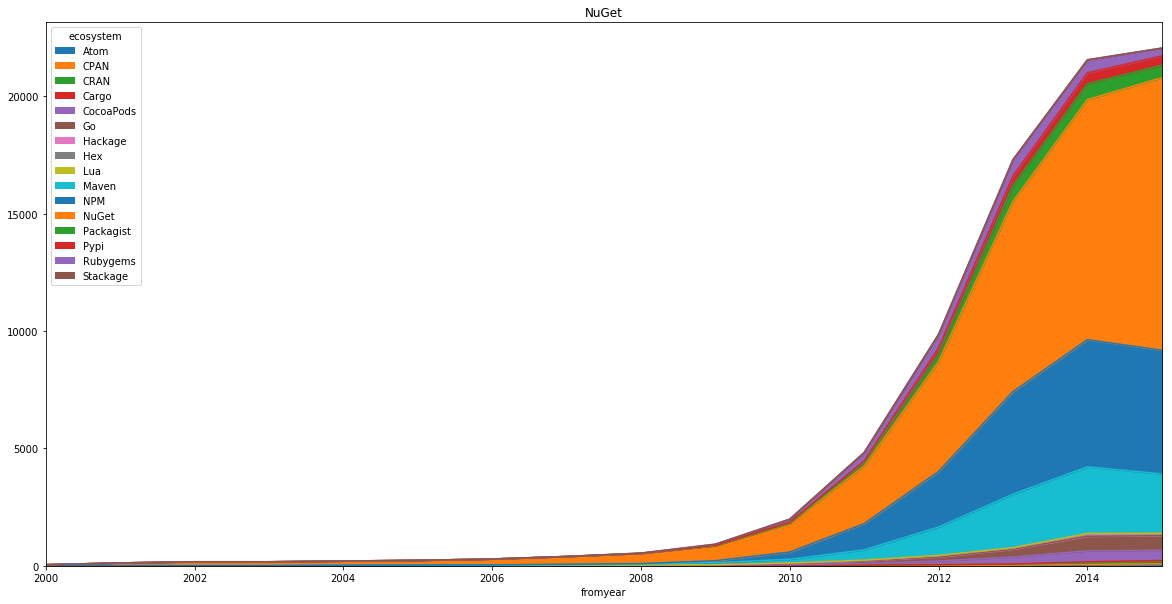

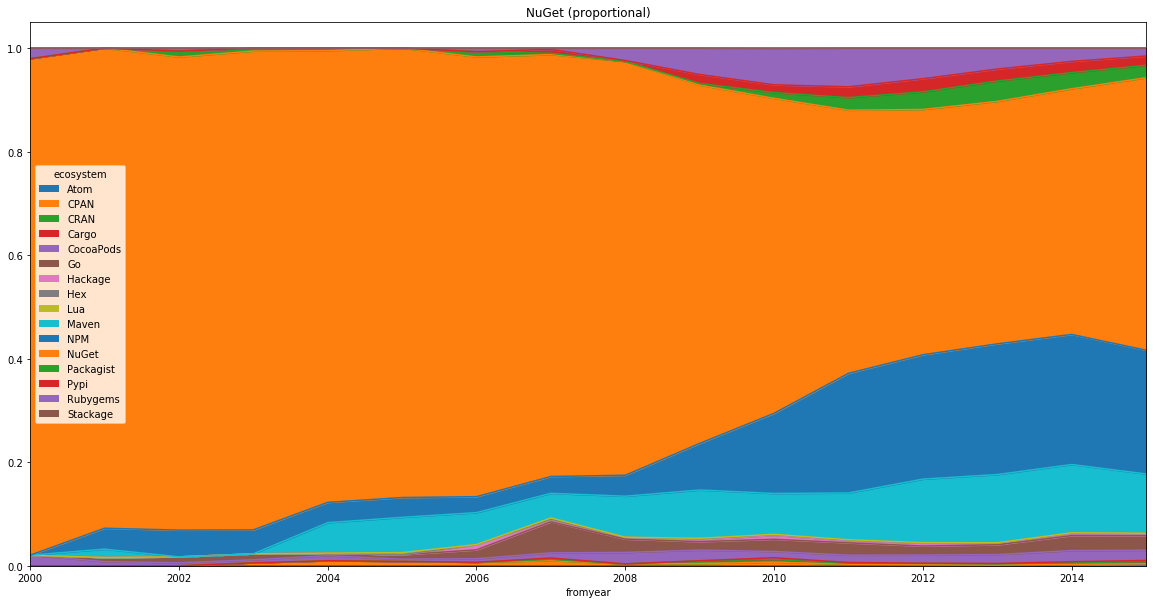

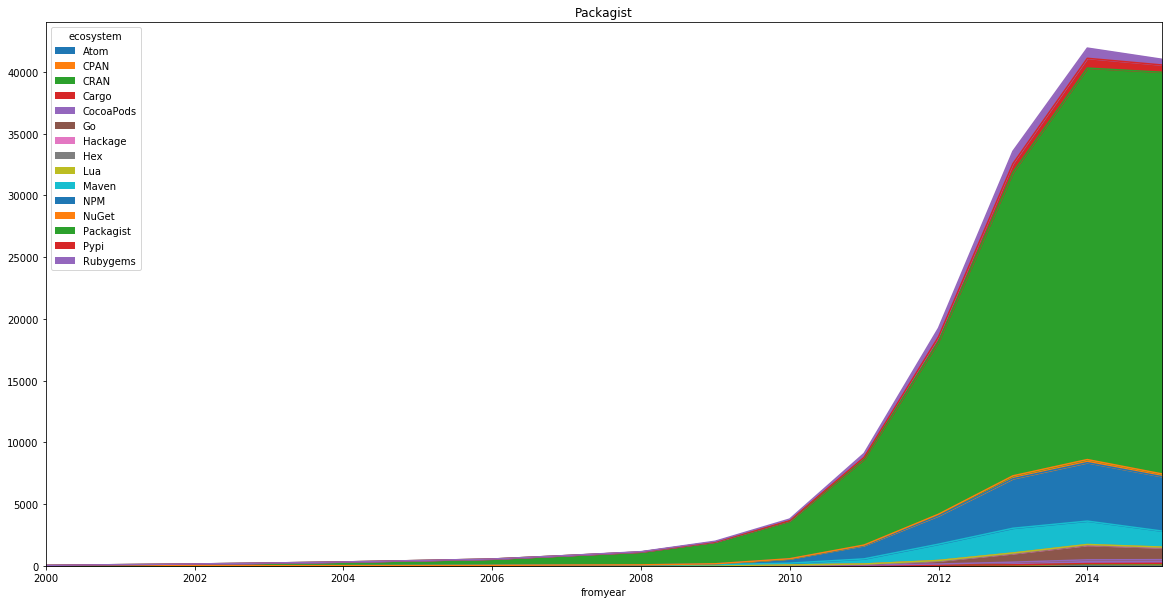

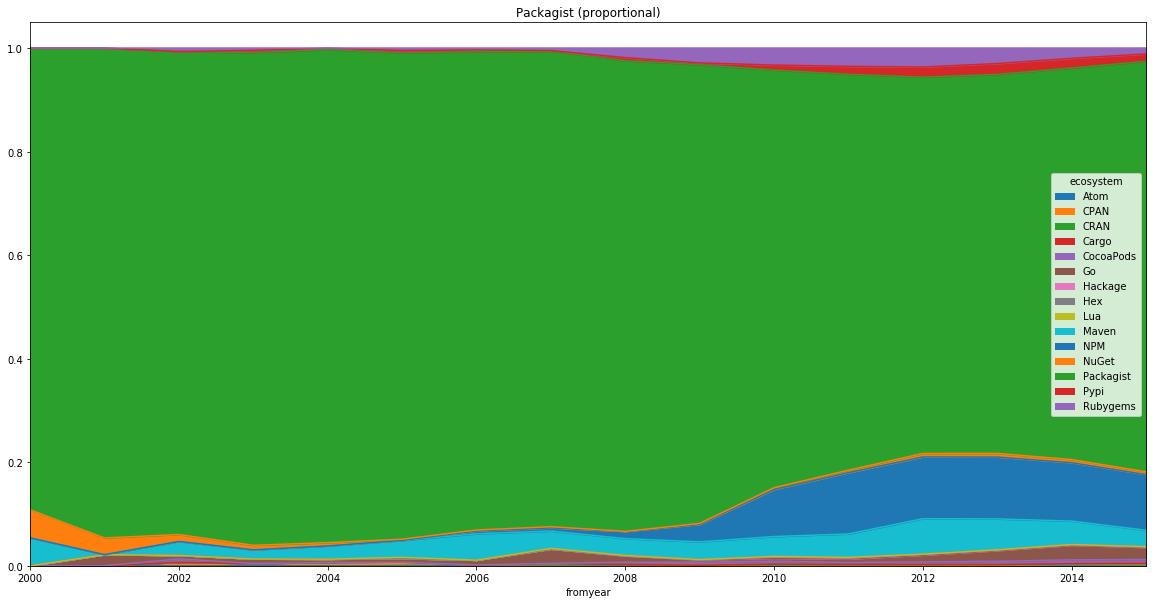

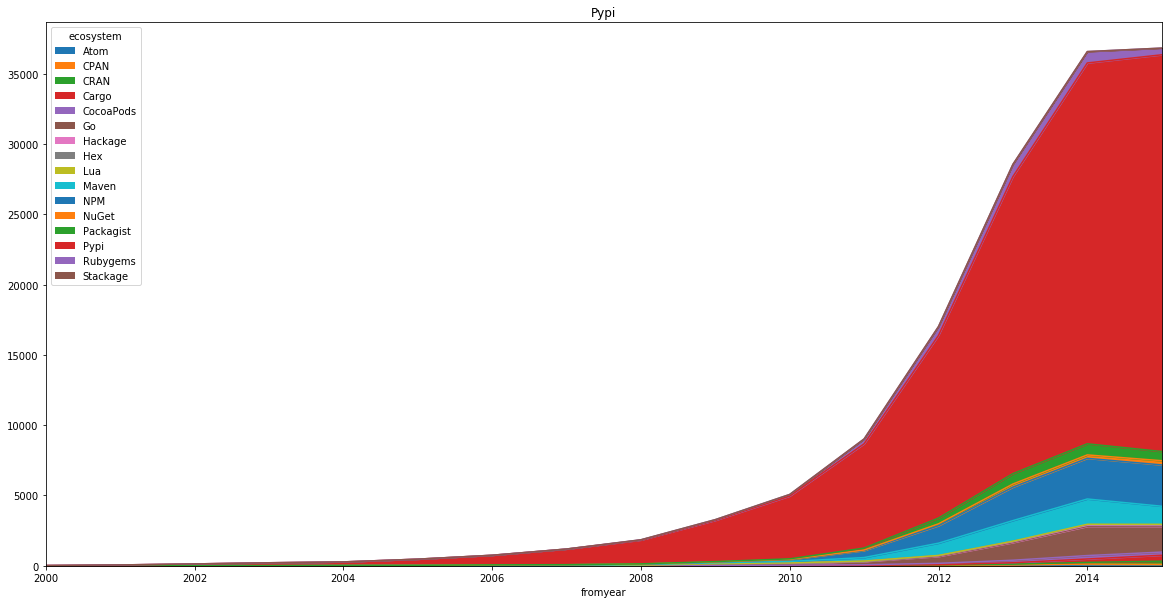

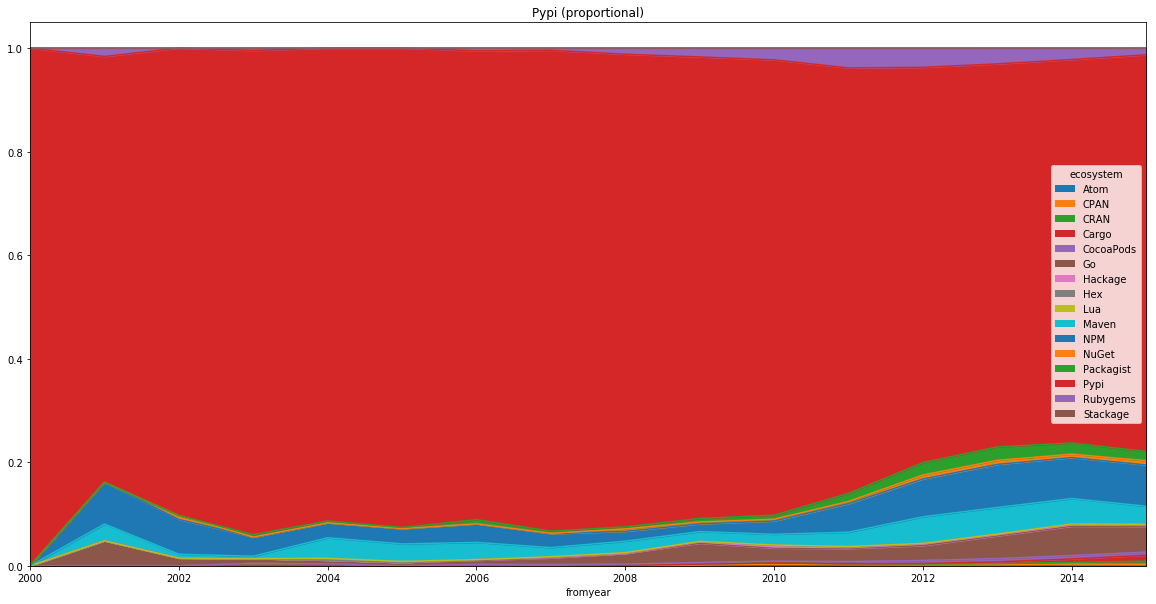

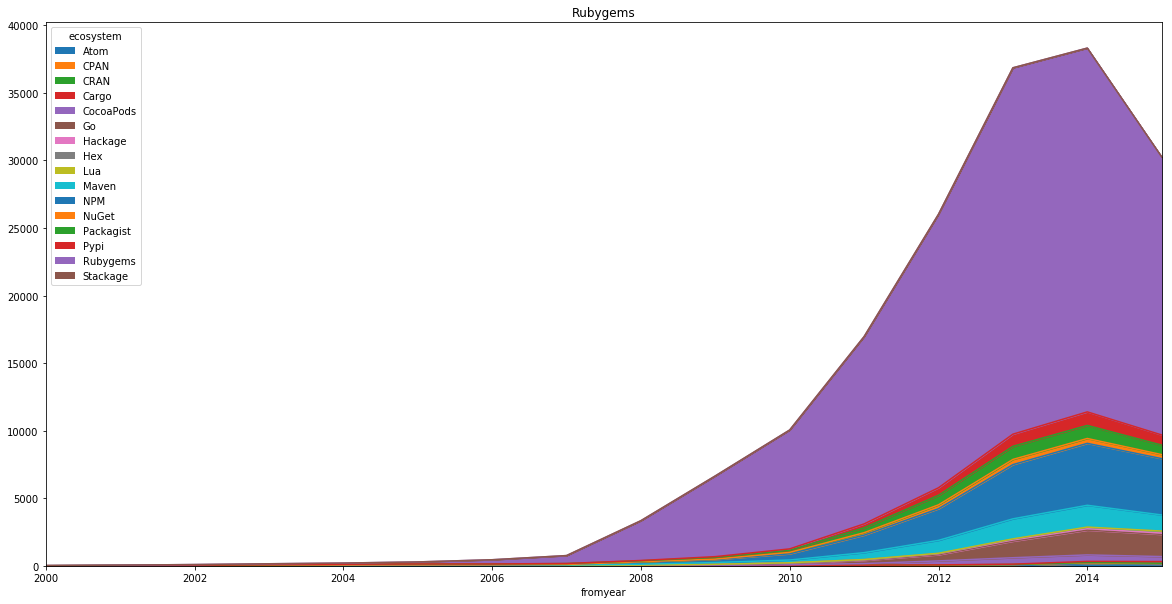

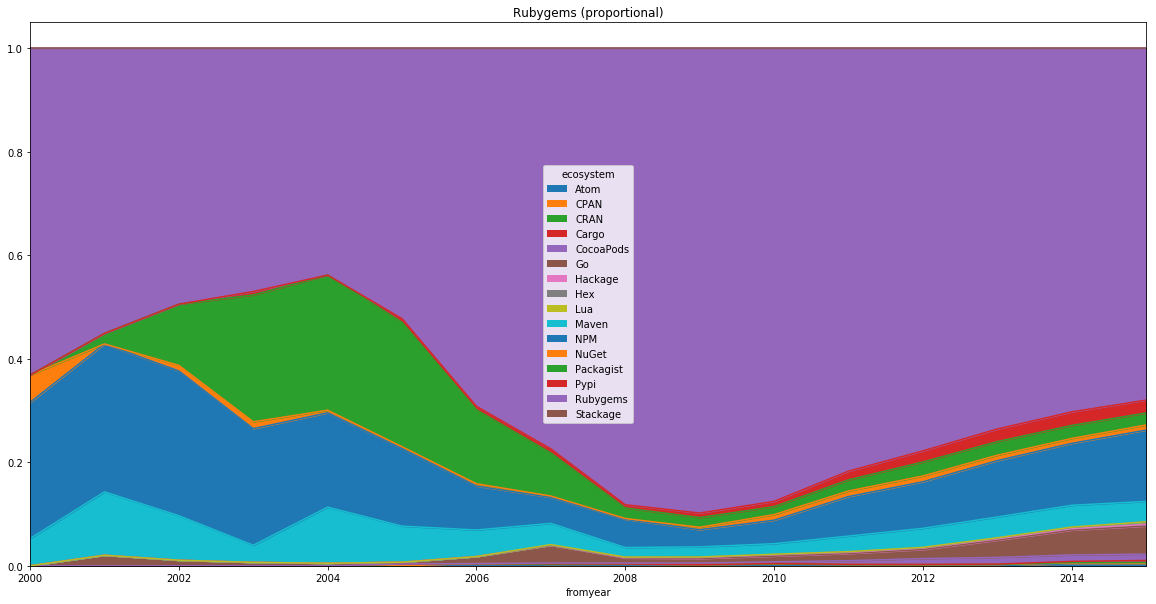

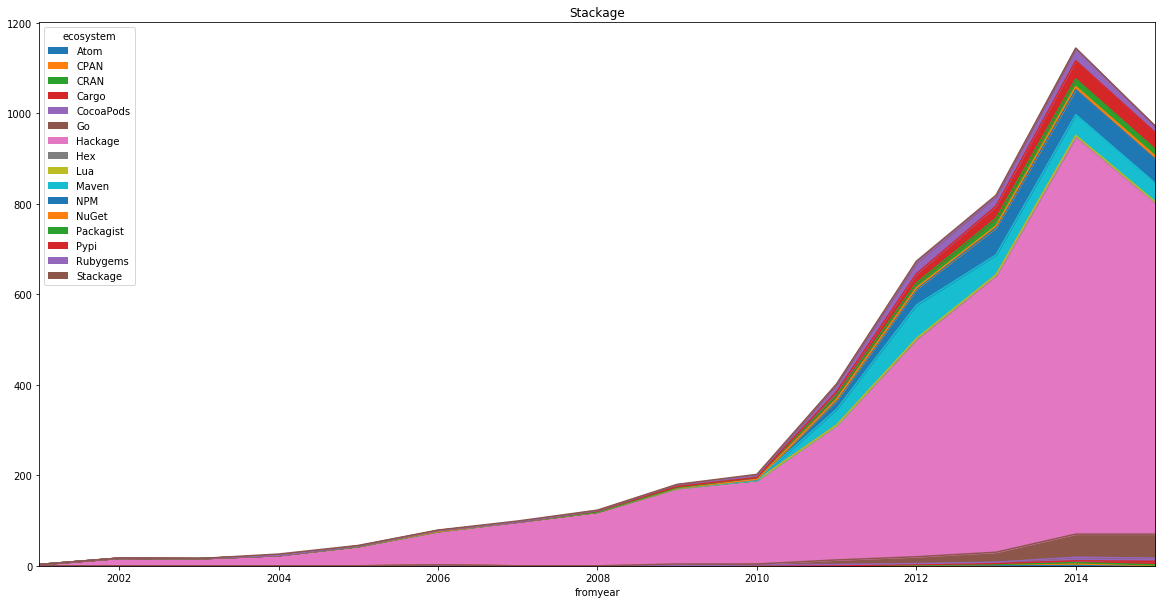

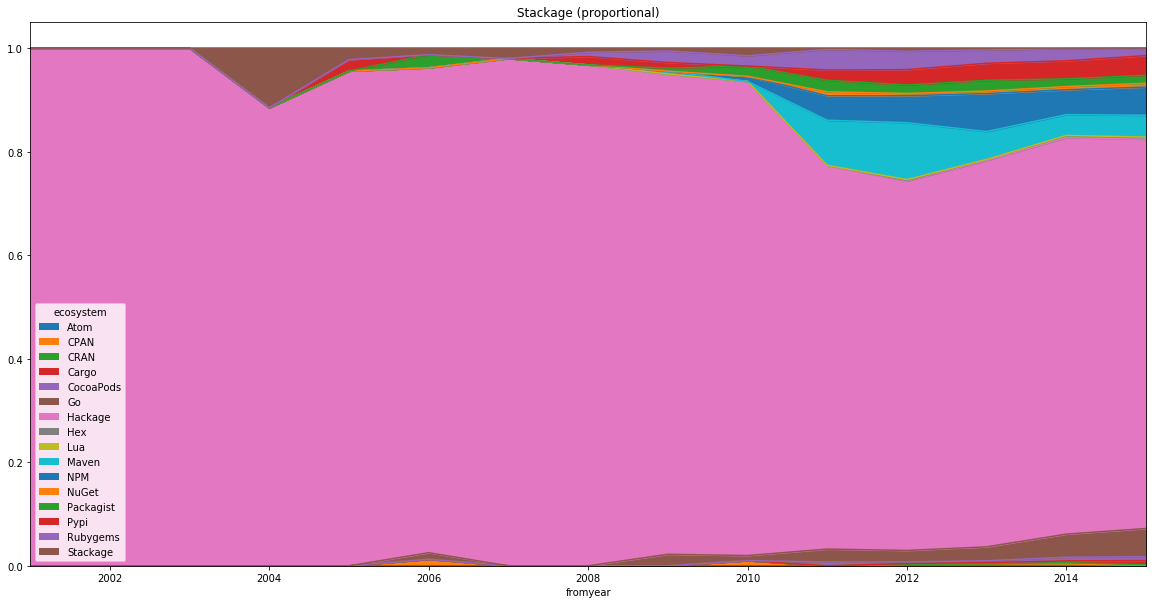

In [16]:
for e in ecos["ecosystem"]:
    draw_ecosystem_influences(e)

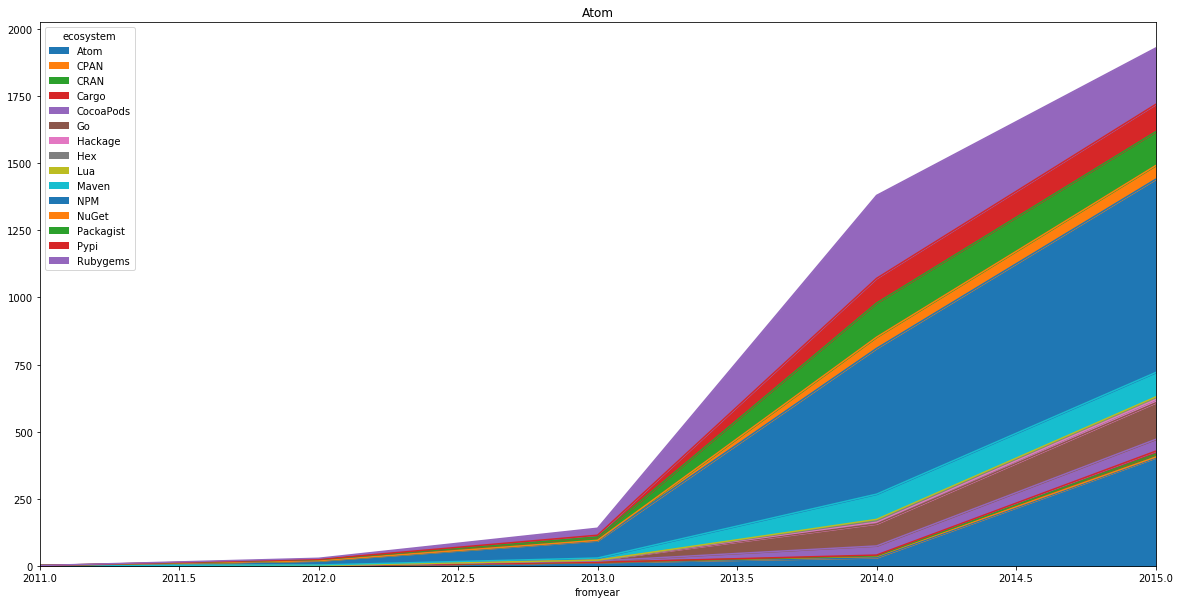

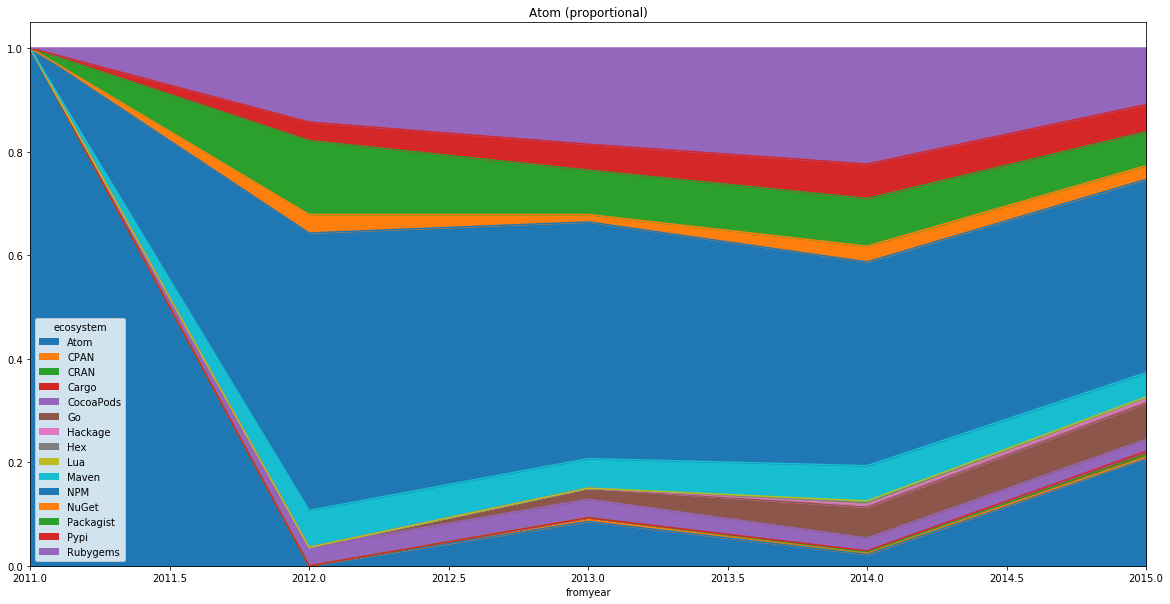

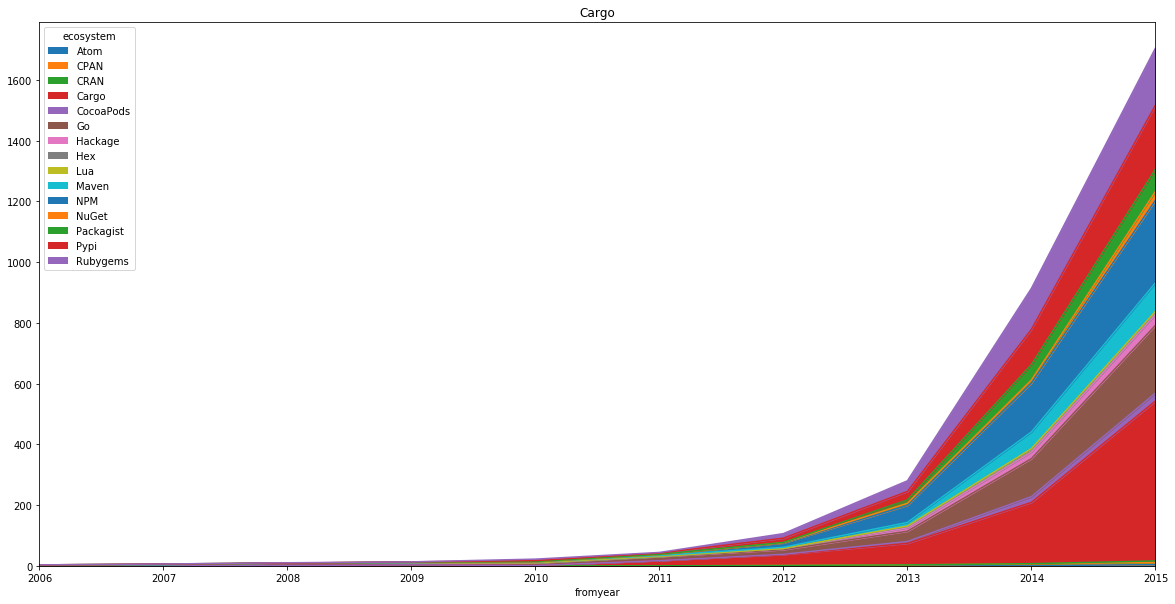

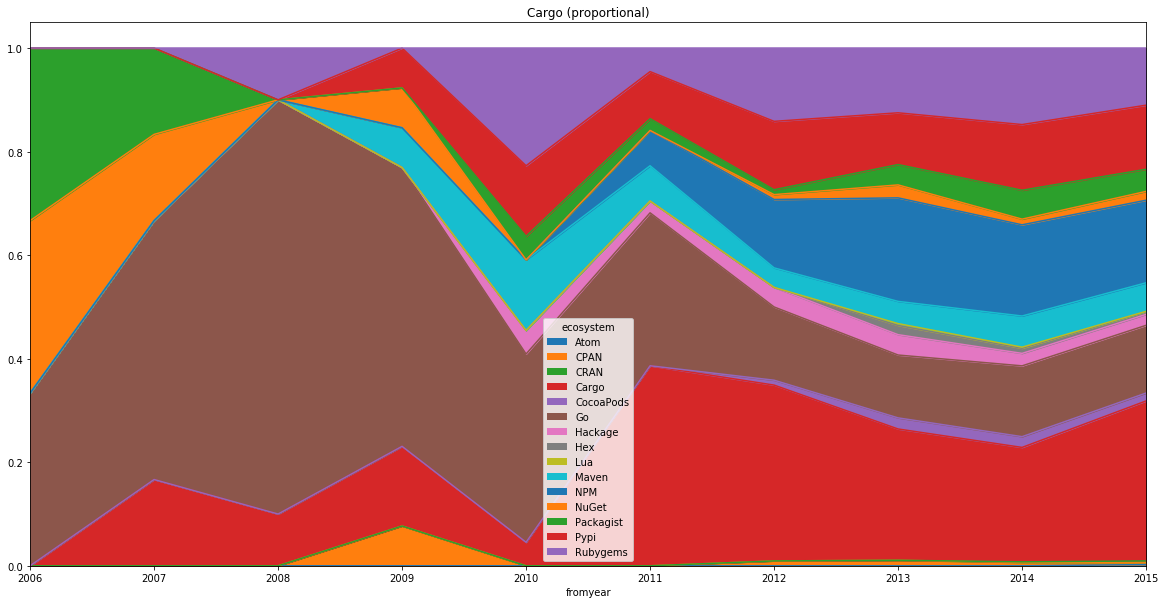

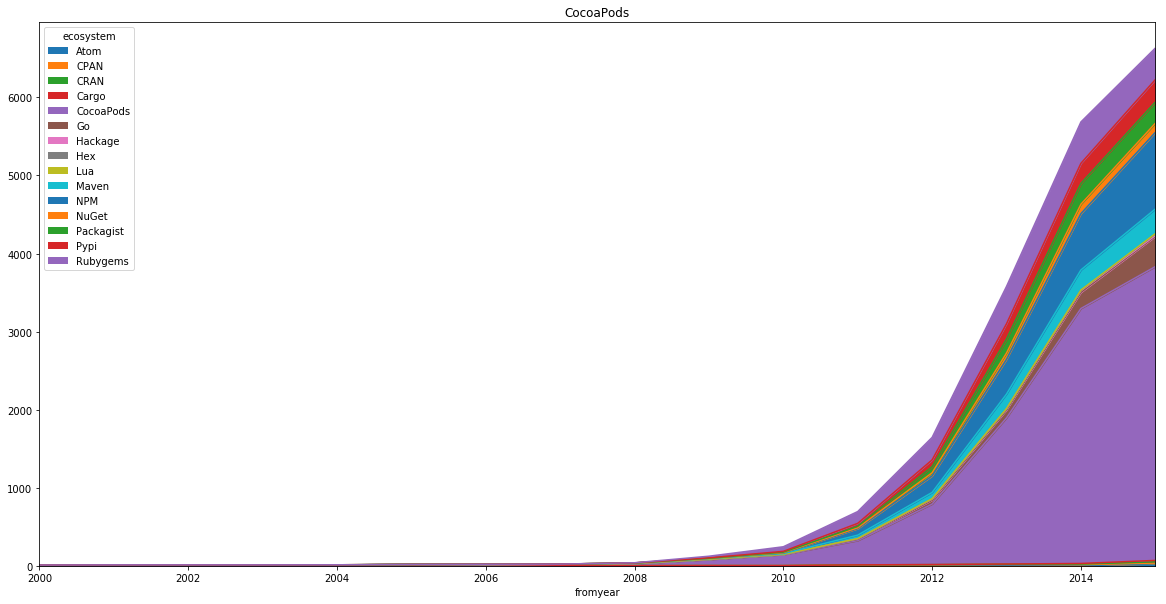

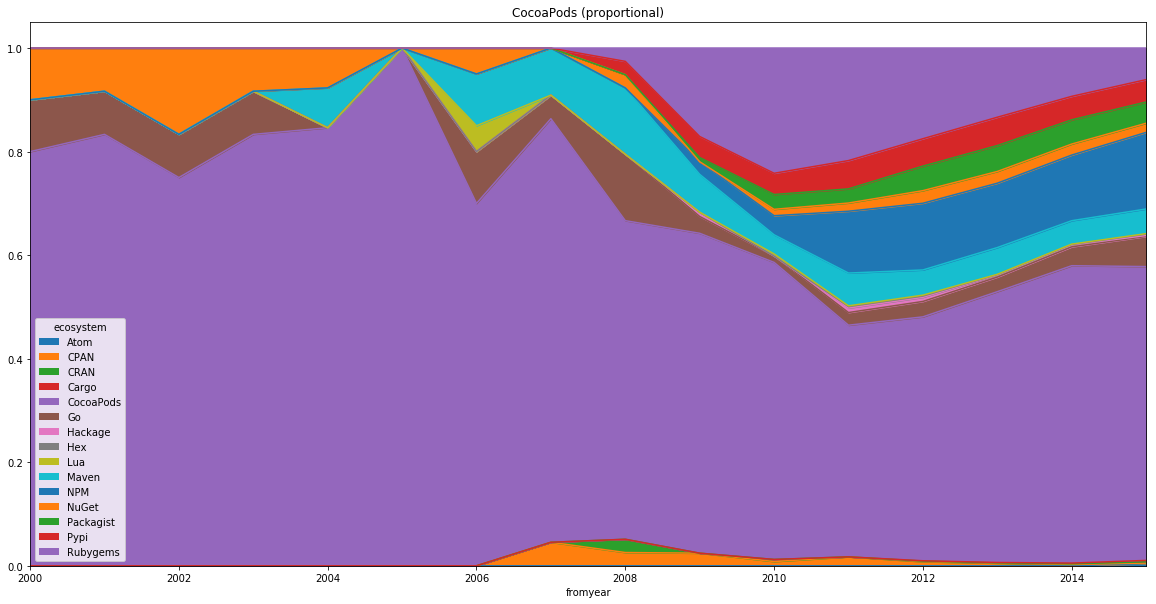

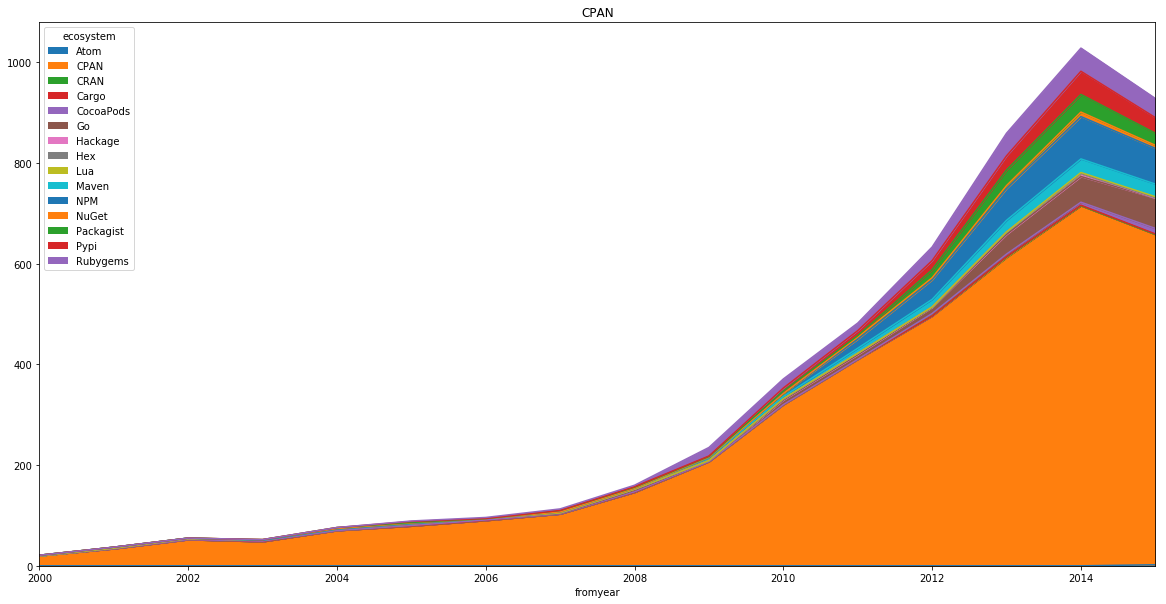

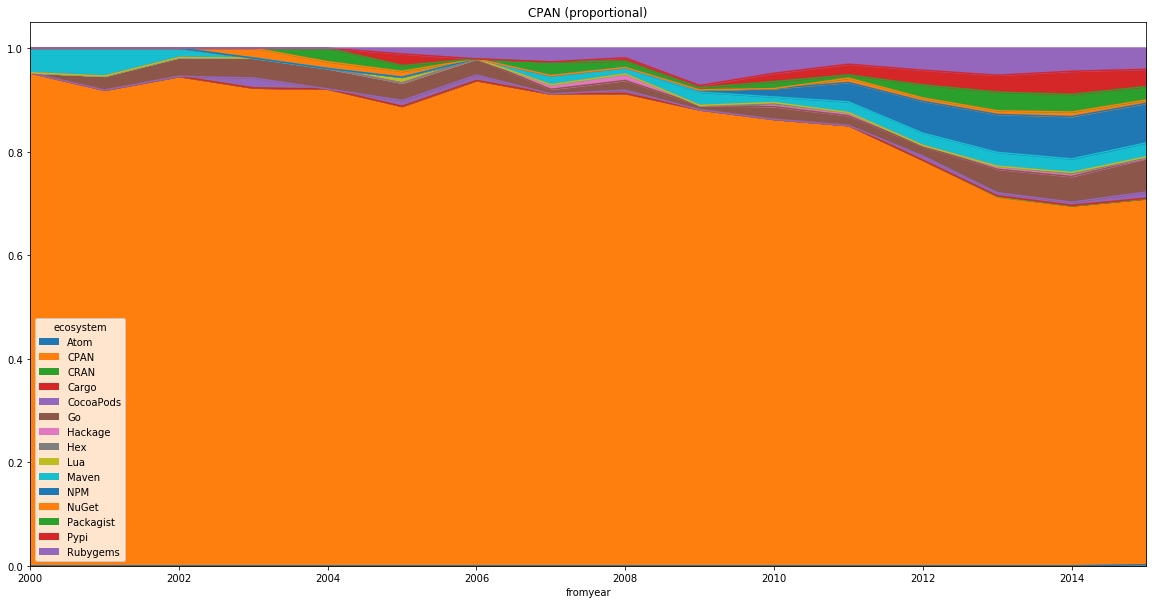

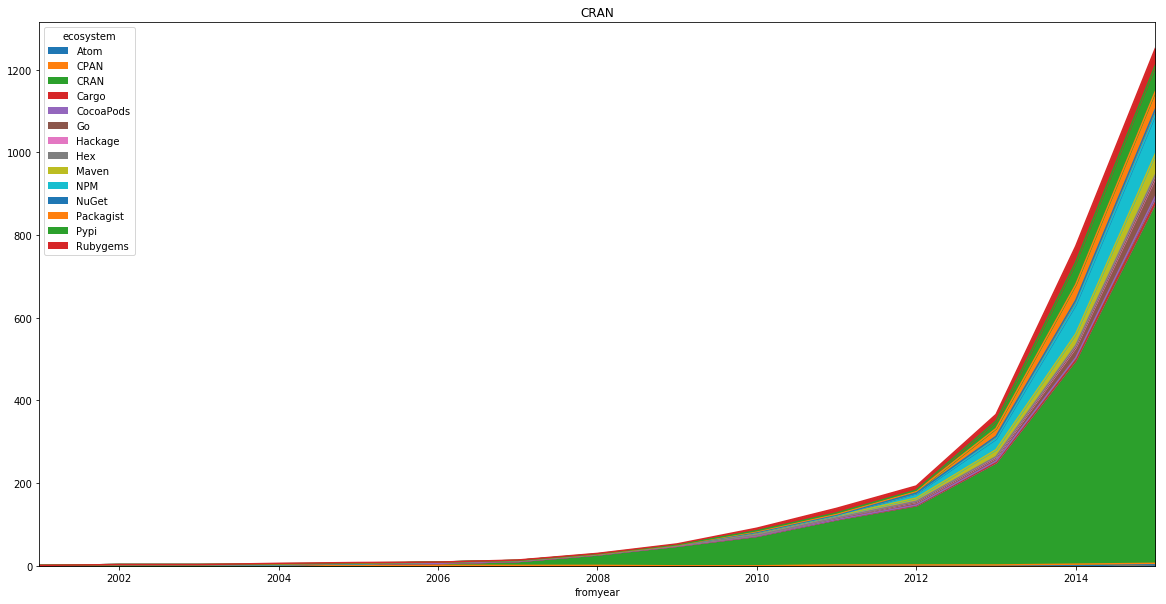

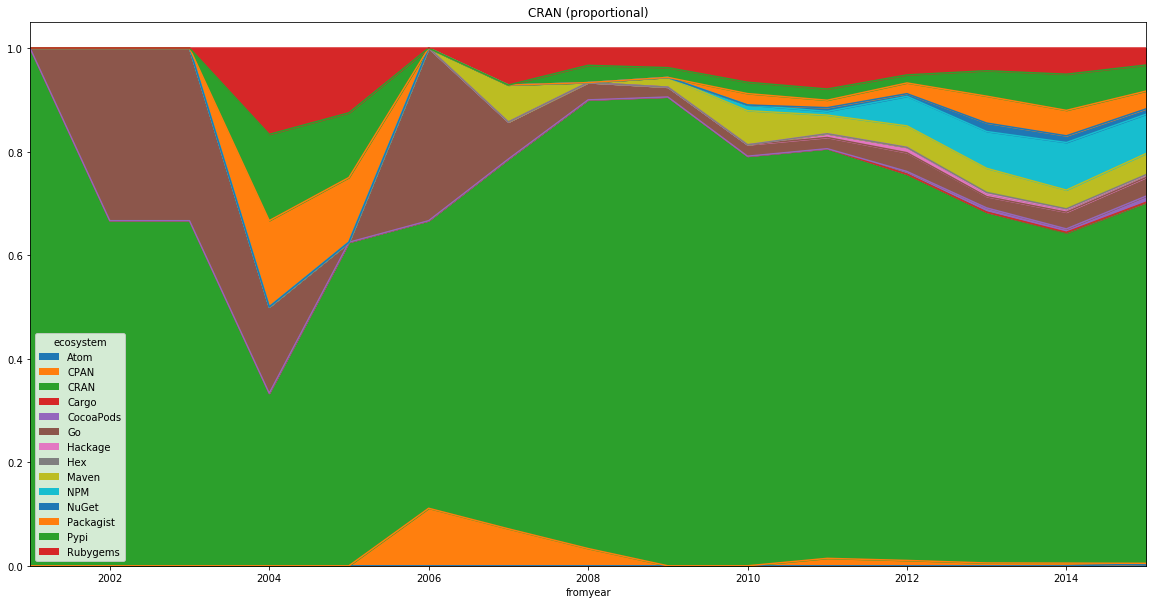

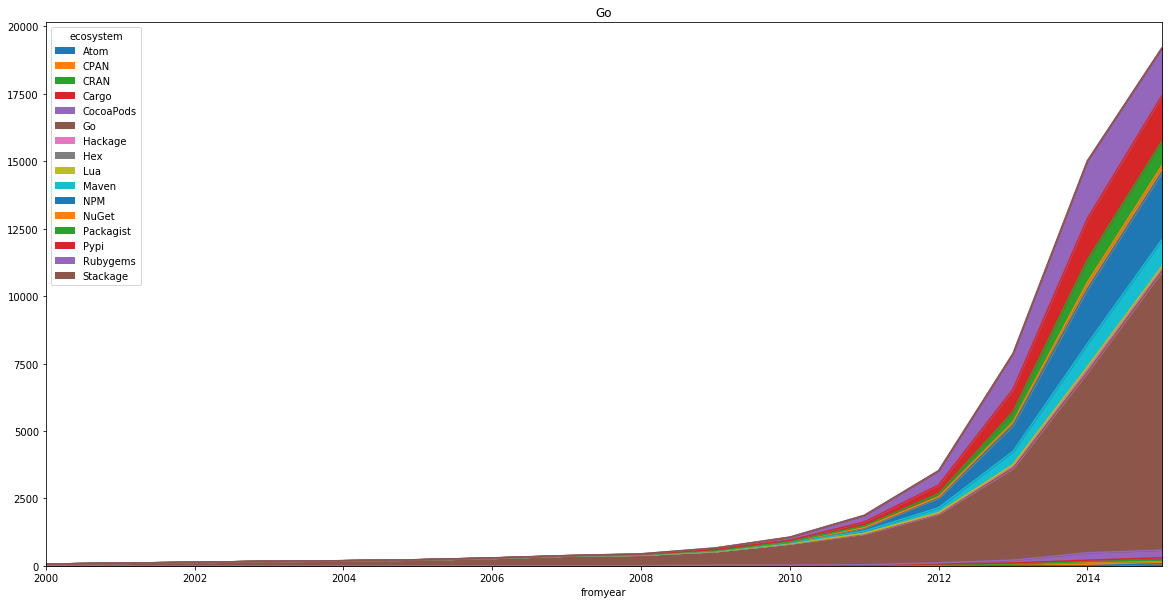

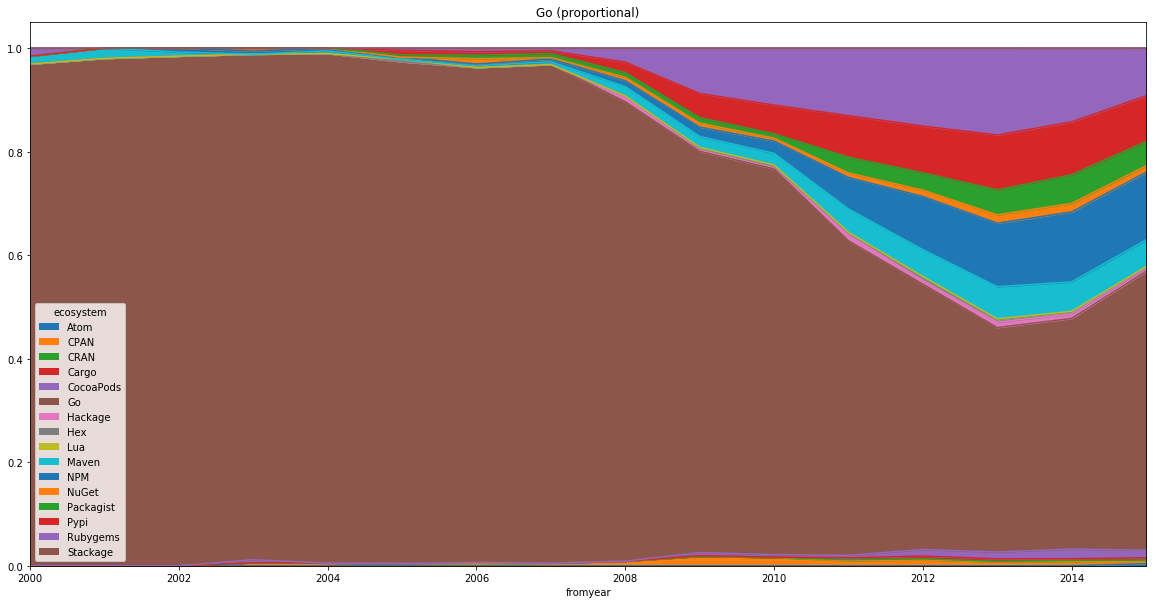

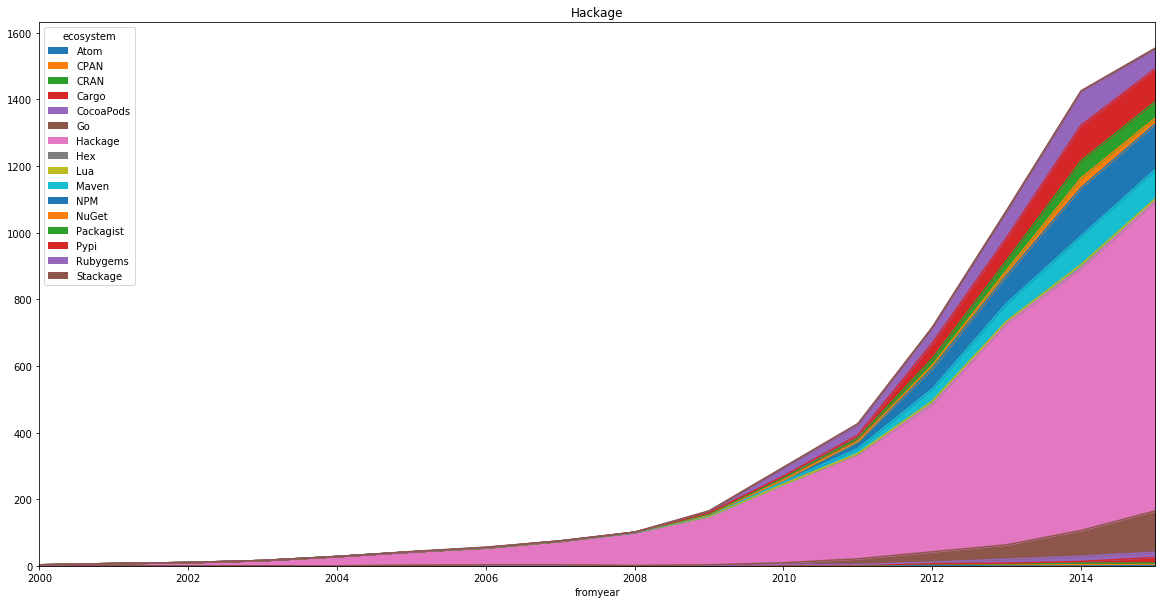

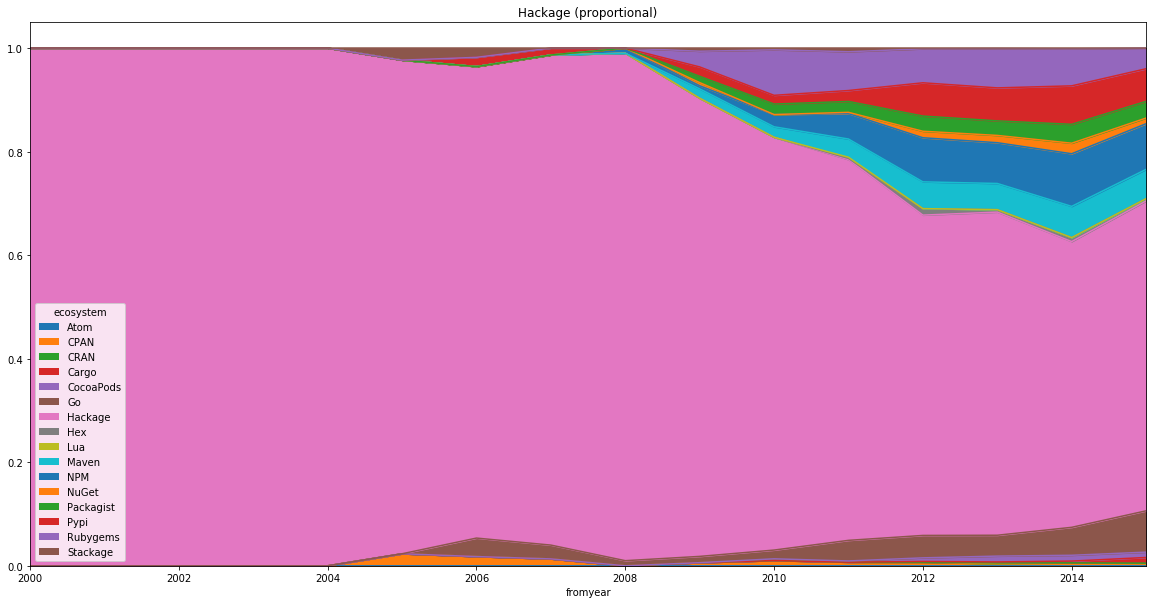

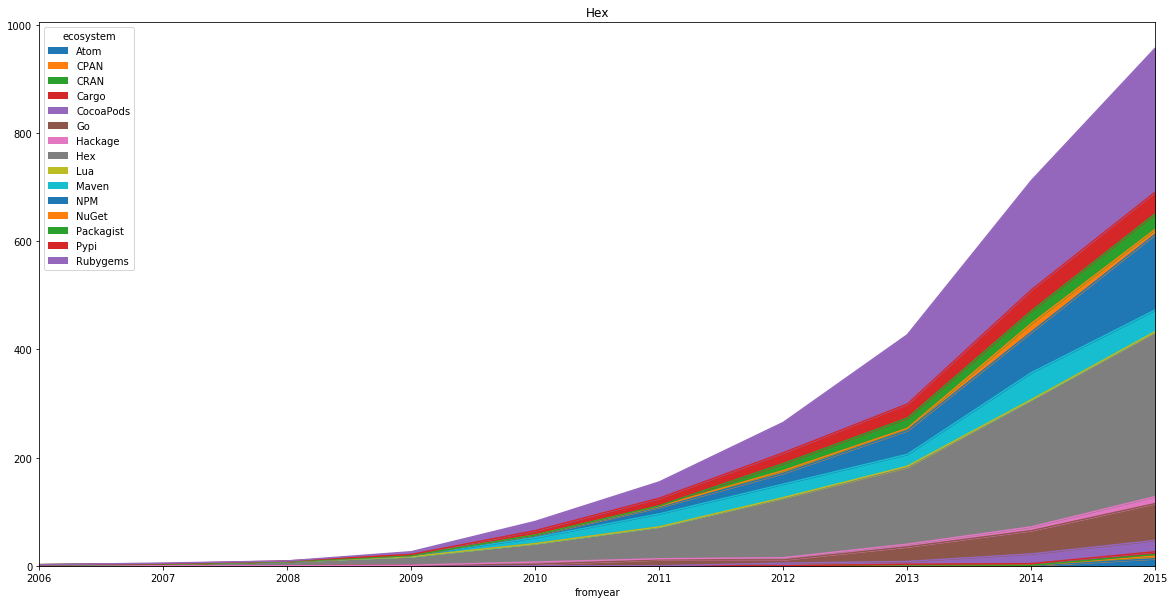

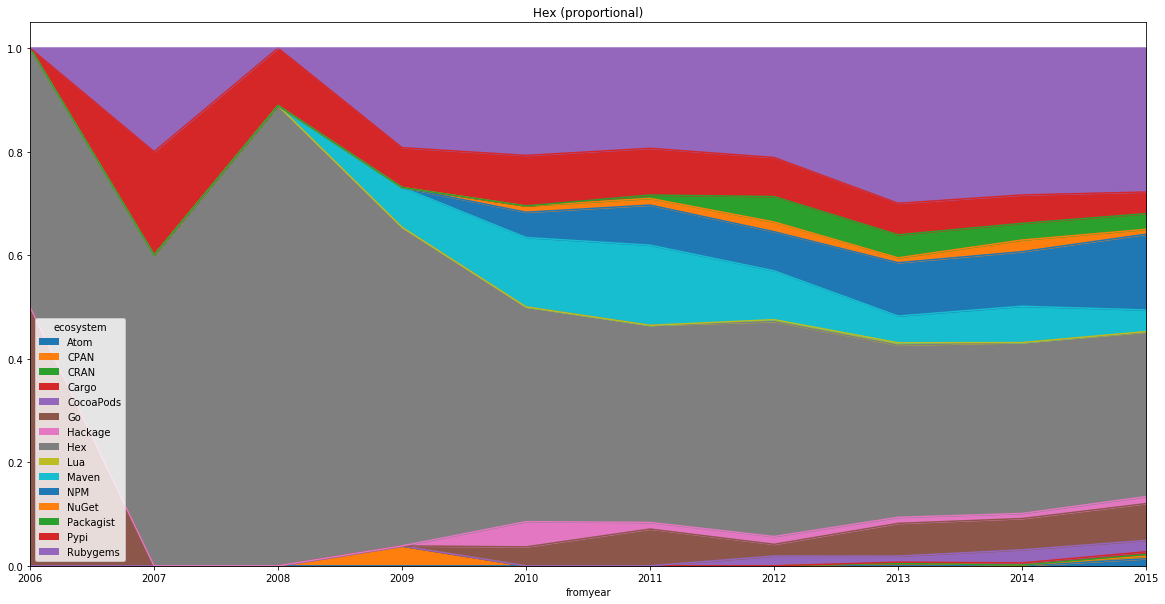

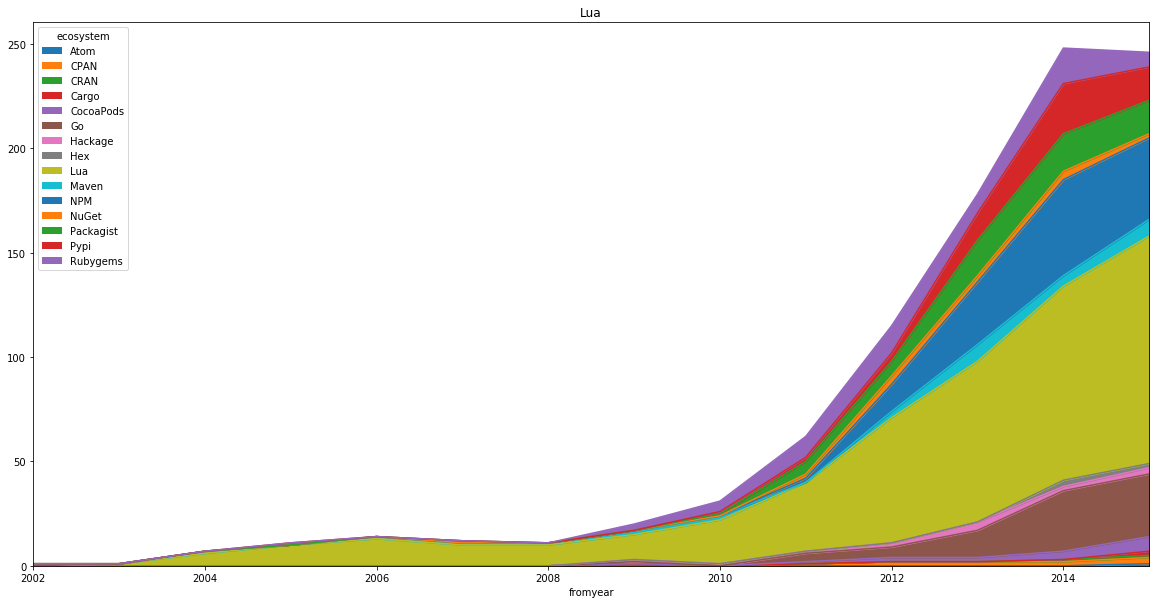

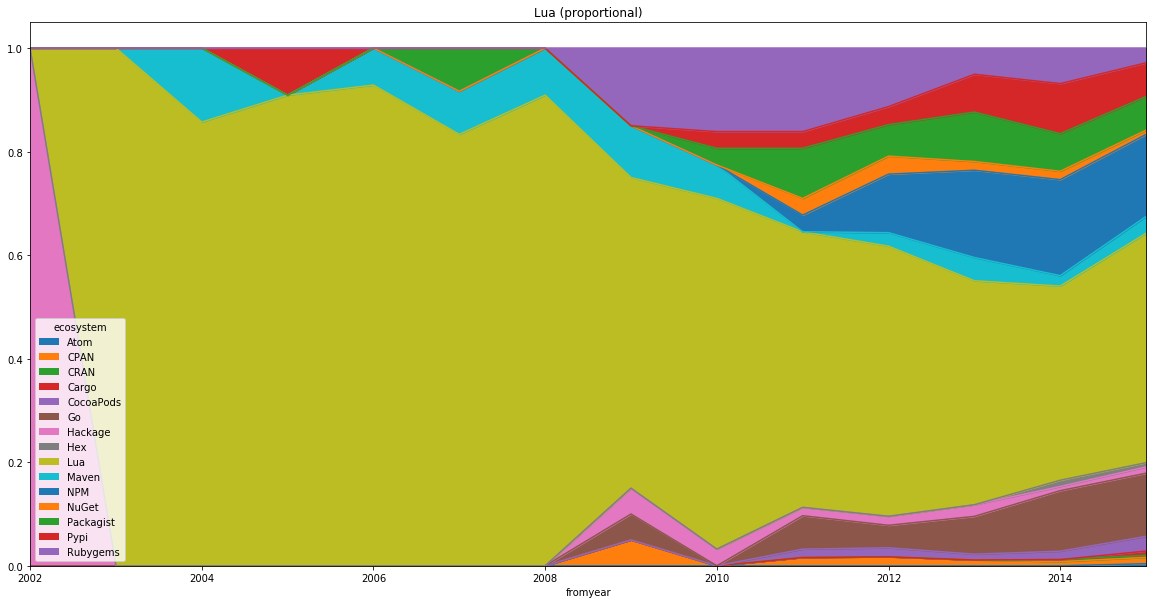

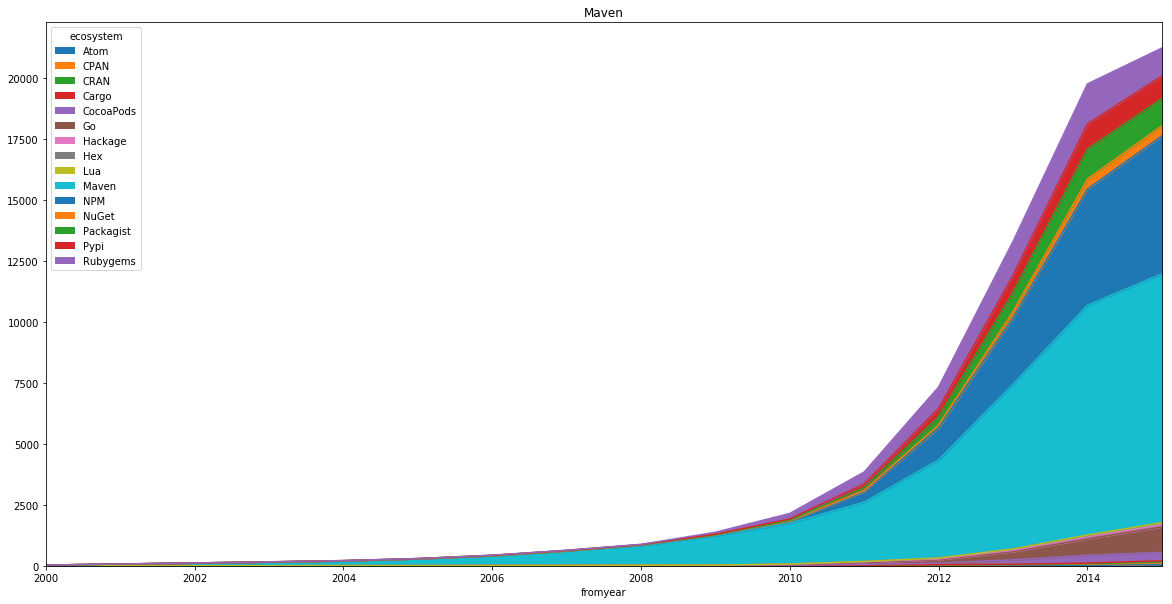

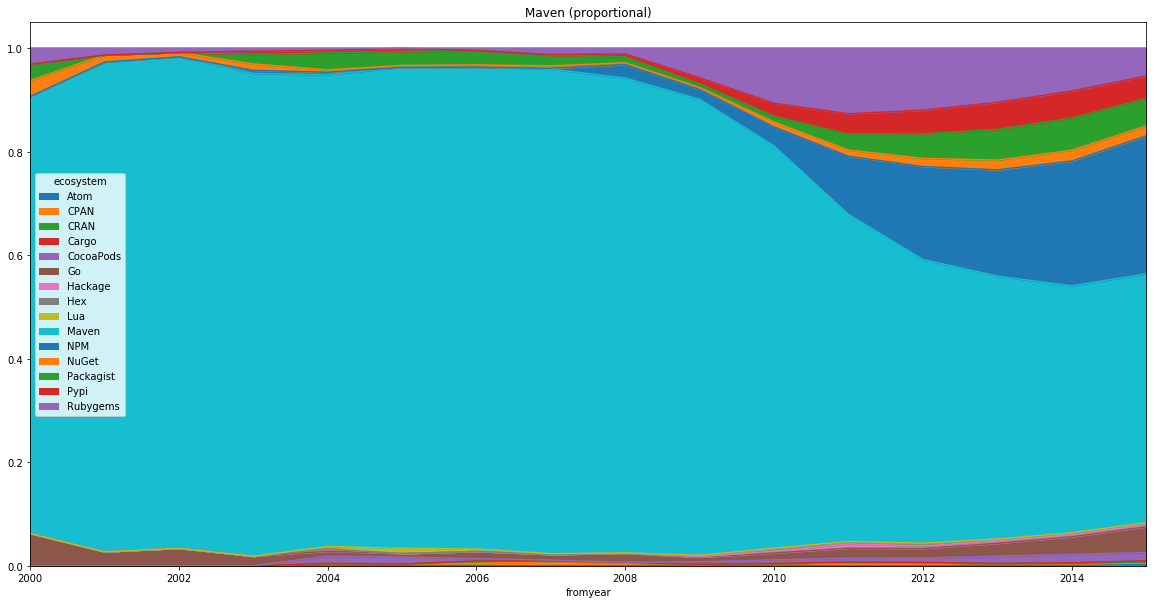

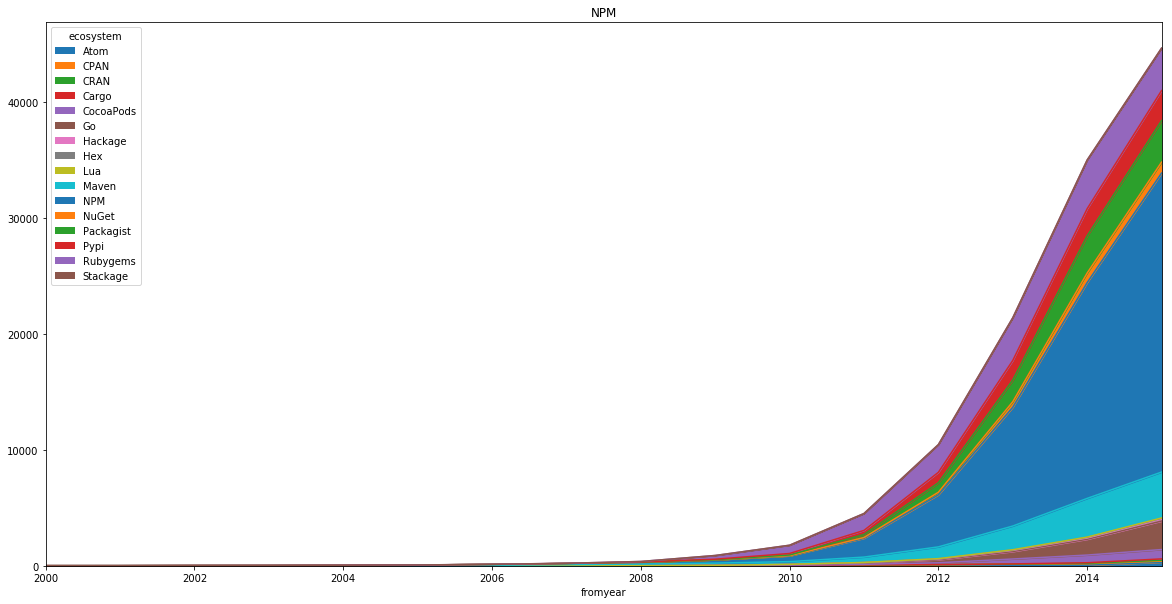

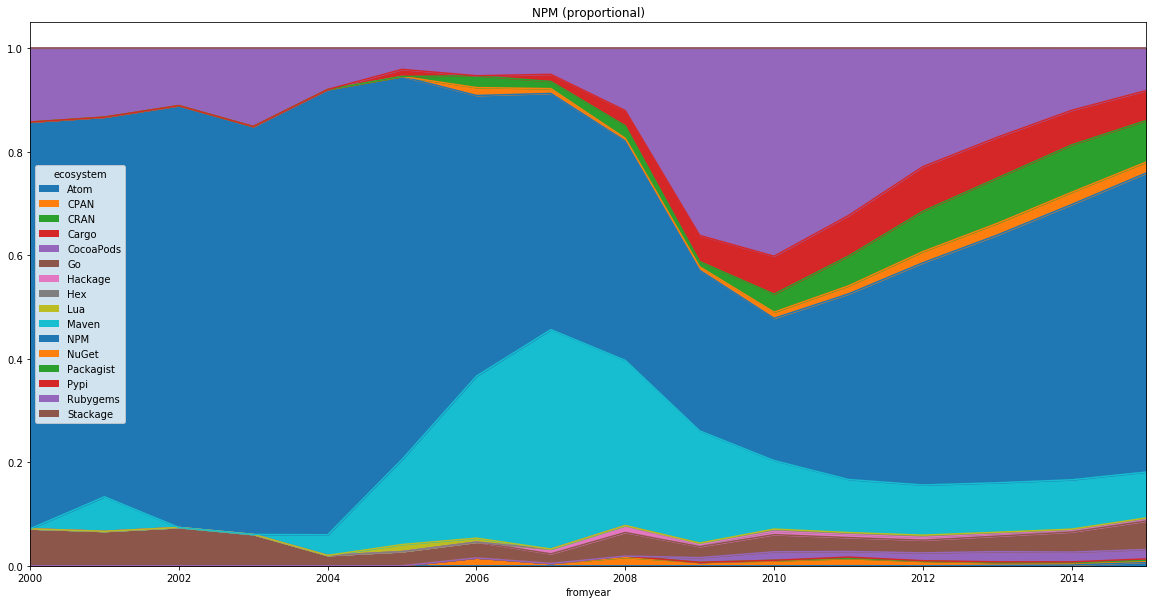

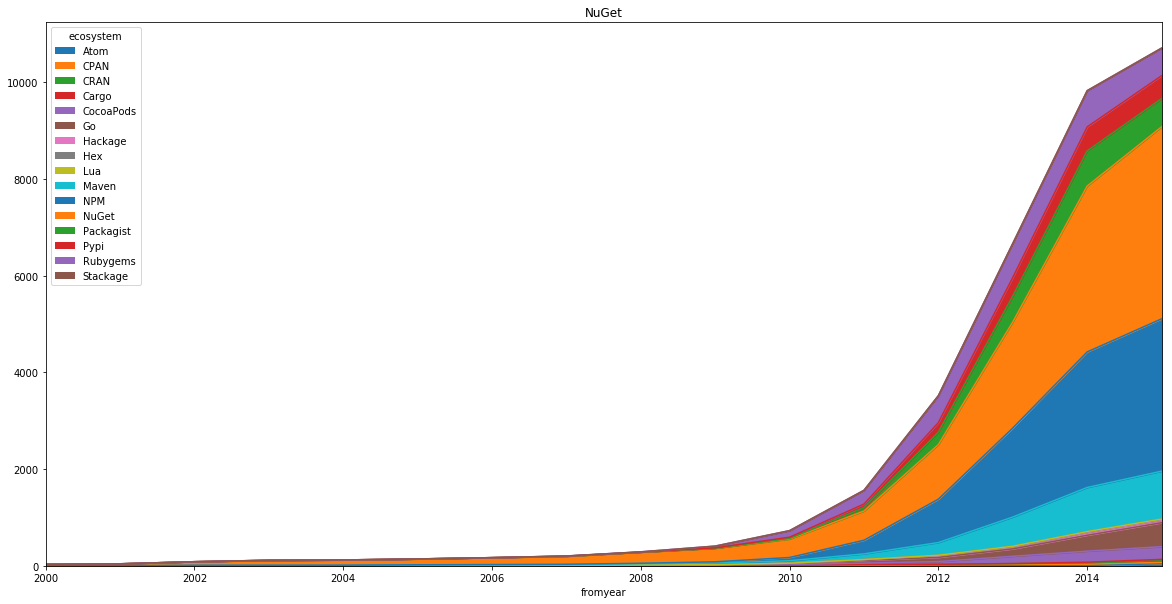

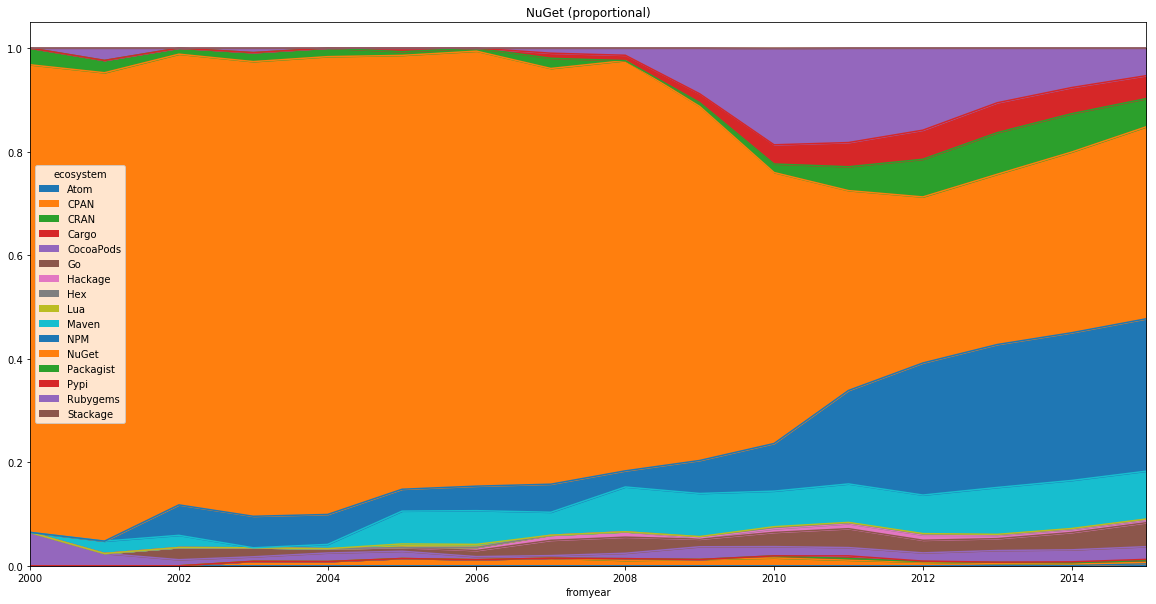

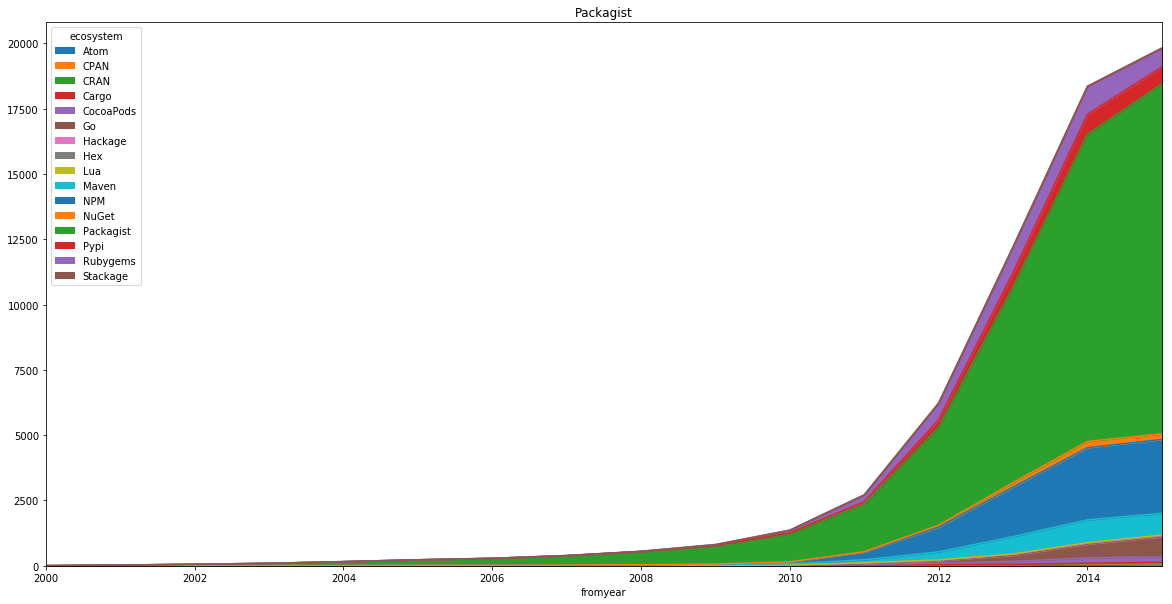

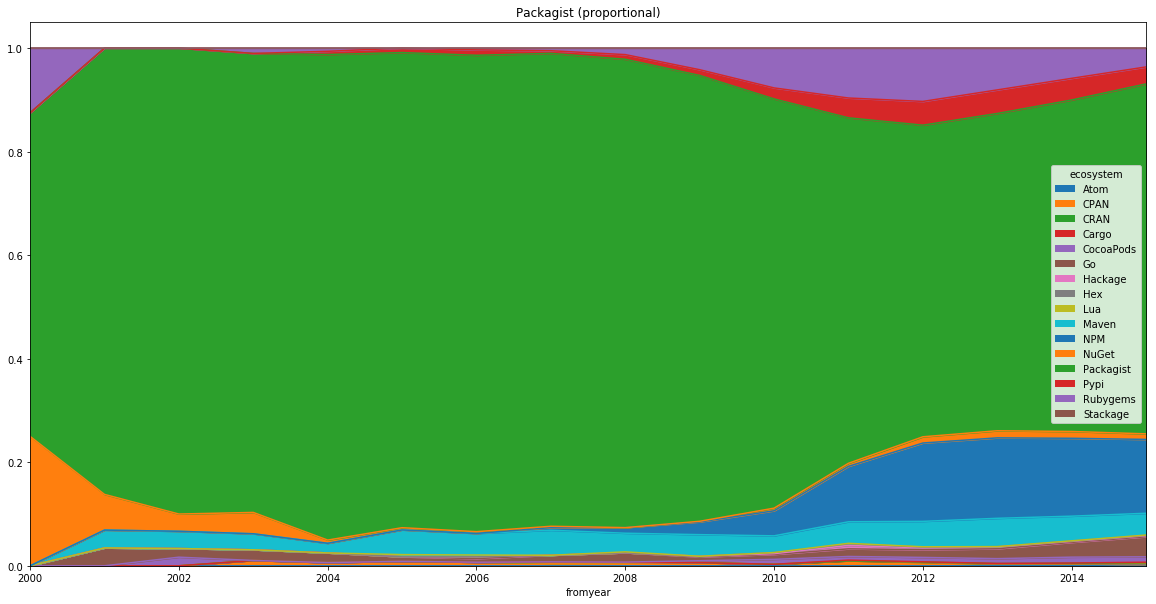

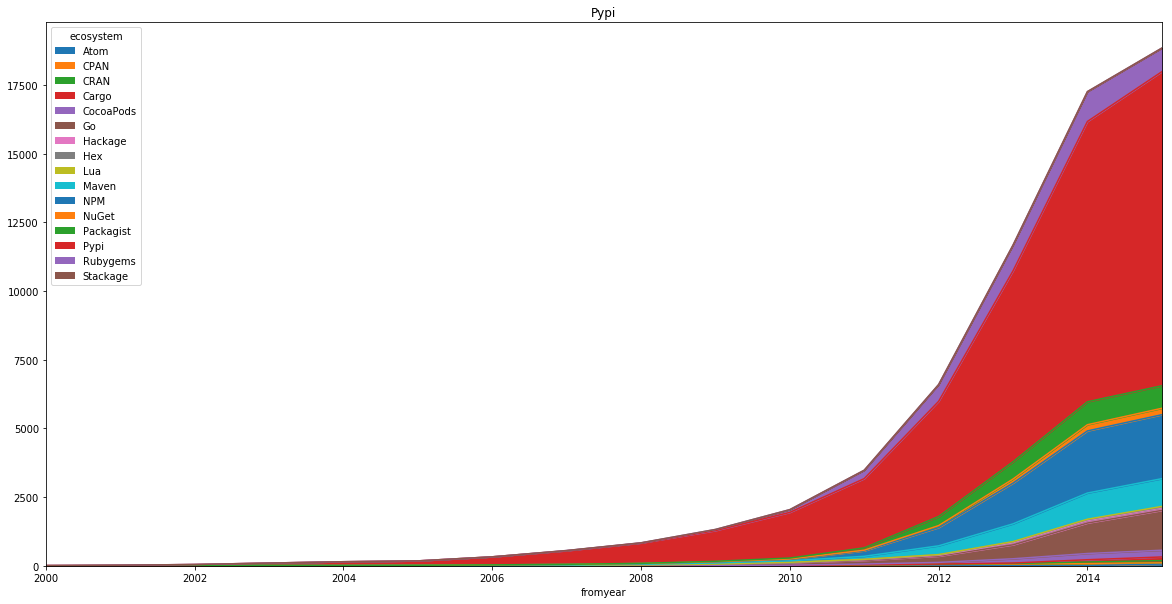

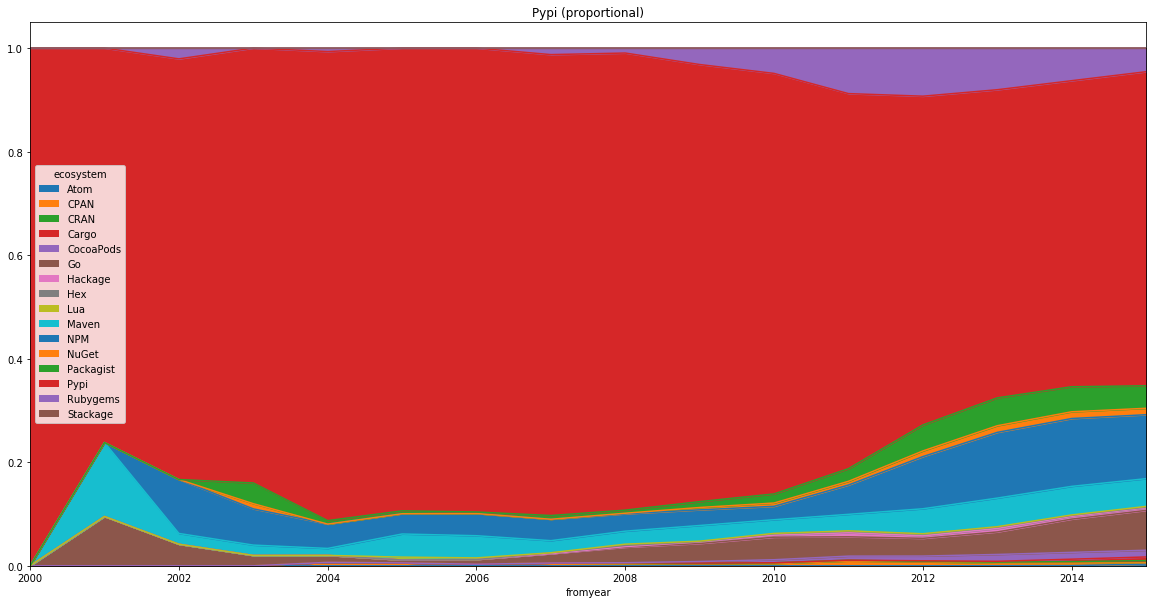

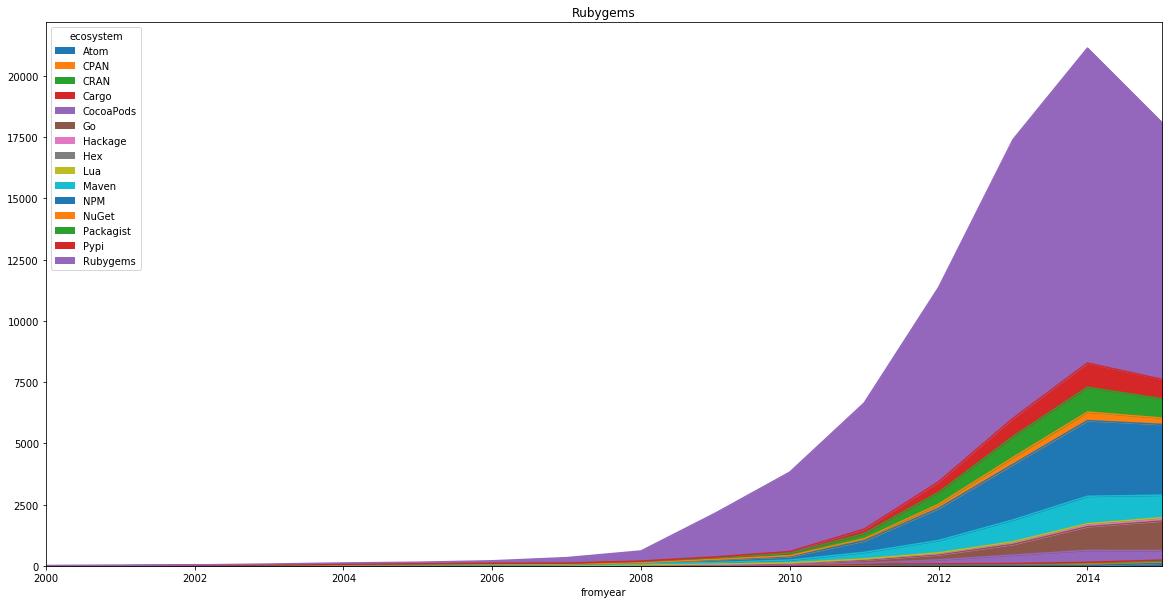

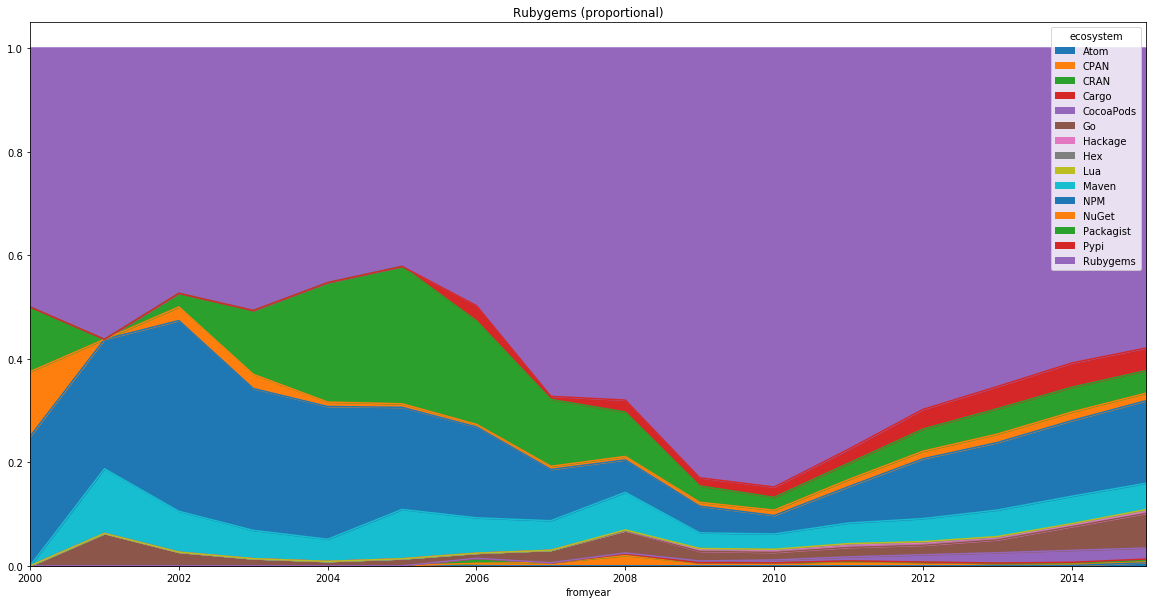

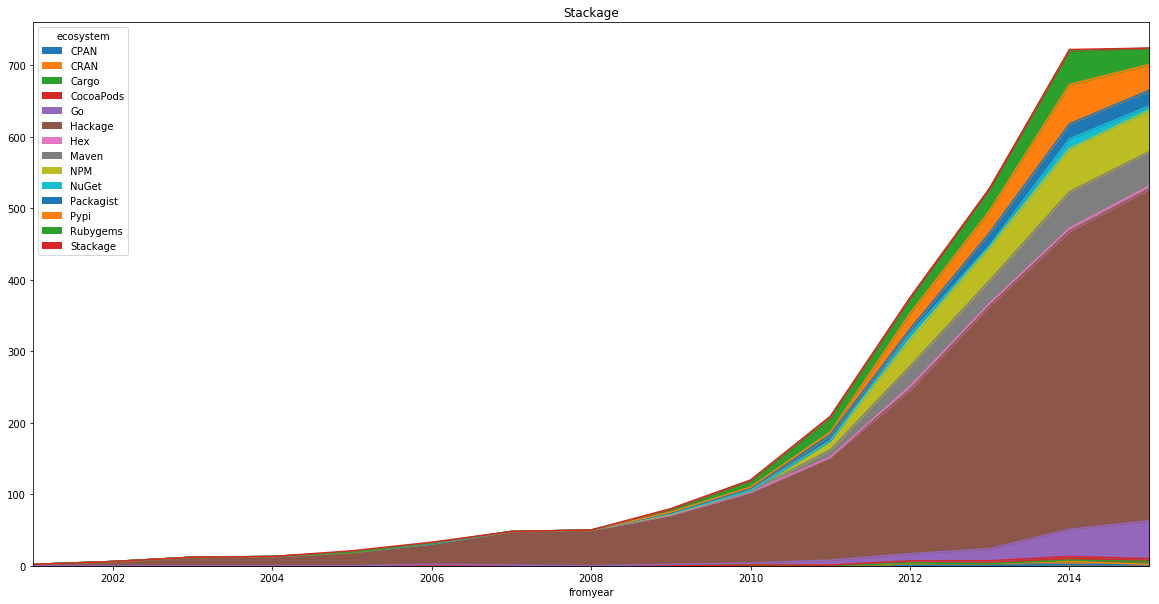

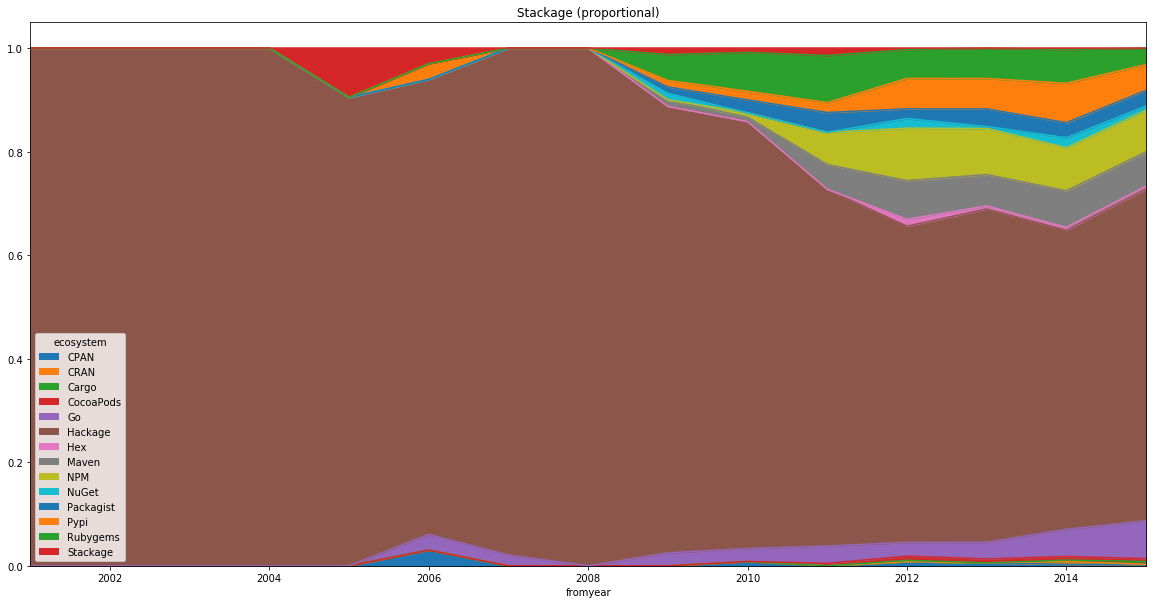

In [18]:
for e in ecos["ecosystem"]:
    draw_ecosystem_influences_prior_year(e)